### Data de entrega: XX/XX/XXXX
_________

# Projeto módulo ML I ML II e MLIII - Crédito para Financiamento de Imóveis


____________


## Contextualização

A PyCoders Ltda., cada vez mais especializada no mundo da Inteligência Artificial e Ciência de Dados, foi procurada por uma fintech para desenvolver um projeto de concessão de crédito para imóveis. Nesse projeto, espera-se a criação de valor que **discrimine ao máximo** os **bons pagadores** dos **maus pagadores**. 

Para isso, foi disponibilizada uma base de dados com milhares de casos de **empréstimos do passado** com diversas características dos clientes. 

Entrega: um modelo com a **melhor performance** possível.

Métrica de performance (inicialmente proposta): **ROC-AUC** (mas isso é flexível, conforme detalhado mais abaixo!)


## Base de Dados

Serão utilizadas bases de dados com **informações cadastrais, histórico de crédito e balanços financeiros de diversos clientes**. 

O conjunto de dados está dividido em **treino e teste**, todos no formato csv. 

Toda a modelagem, validação e avaliação deve ser feita em cima do conjunto de **treino**, que contém o target (arquivo: `aplication_train.csv`)

Há uma base já pronta, mas as demais bases auxiliares também serão disponibilizadas (sintam-se à vontade para explorá-las e utilizar as informações que julgarem relevantes!)

[Clique aqui](https://drive.google.com/file/d/17fyteuN2MdGdbP5_Xq_sySN_yH91vTup/view) pra baixar os dados (eles estão disponiveis no arquivo zipado `credito-imoveis.zip`).

## Regras de Entrega

Deve ser entregue um arquivo csv com as **predições** para a base de teste.

Essa base deverá ser um Data Frame com duas colunas: a primeira sendo o **SK_ID_CURR** e a segunda a **probabilidade de inadimplência.**

### IMPORTANTE!

Entregar as predições com a **probabilidade da inadimplência ocorrer**, não a classe predita (pois eu irei calcular a AUC de teste, com os targets que eu tenho disponível ;D (mas depois vou compartilhar com vcs tbm!))

Além do arquivo com as predições, claro, entreguem também o notebook com o código utilizado. É importante que ele tenha:

- (i) a análise exploratória e construção das variáveis explicativas;

- (ii) a análise de modelagem, mostrando o processo das avaliações dos modelos e os motivos das decisões tomadas sobre qual modelo usar.

## Dicas


Explorar o conceito das variáveis: existe risco de imagem uma empresa utilizar variável de sexo para determinar risco de crédito? Vale a pena trazer a variável para o modelo?

Criar novas variáveis usando as variáveis que já estão na base: criatividade!

Qualquer dúvida, só me chamar! ;)


# Importando as ferramentas

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import normaltest, skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score,classification_report, confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from skopt import BayesSearchCV
warnings.filterwarnings('ignore')



In [2]:
def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)
    y_probs_train = estimator.predict_proba(X_train)[:, 1]

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train,cmap='cividis')
    plt.show()

    print(classification_report(y_train, y_pred_train))
    
    disp = RocCurveDisplay.from_predictions(y_train, y_probs_train)
    disp.ax_.set_title(f"AUC: {roc_auc_score(y_train, y_probs_train):.3f}", fontsize=16)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, ls=":", color="black")
    plt.show()

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)
    y_probs_test = estimator.predict_proba(X_test)[:, 1]

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test,cmap='cividis')
    plt.show()

    print(classification_report(y_test, y_pred_test))
    
    disp = RocCurveDisplay.from_predictions(y_test, y_probs_test)
    disp.ax_.set_title(f"AUC: {roc_auc_score(y_test, y_probs_test):.3f}", fontsize=16)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, ls=":", color="black")
    plt.show()

In [3]:
def features_cat(df, features):

    for i in features:
        
        # Countplot
        fig, ax = plt.subplots(figsize=(16, 3))
        fig.suptitle(f'Variável: {i}', fontsize=14)
        
        sns.countplot(data=df, x=i, hue='TARGET',palette='cividis')
        
        plt.legend(labels=['Bom pagador','Mau pagador'])
        plt.xticks(rotation=90)
        plt.show()

In [4]:
def features_num(df, features):
    
    for feature in features:
        fig, ax = plt.subplots(ncols=2, figsize=(16,3))
        fig.suptitle(f'Variável: {feature}', fontsize=14)

        # Boxplot
        sns.boxplot(data=df, x=feature, ax=ax[0], showmeans=True, palette='cividis')
        ax[0].set_title('Distribuição: Box-Plot')

        # Apresentando as estatísticas
        ax[0].annotate(text=f'Média: {df[feature].mean():.3f}\n'
                            f'Mediana: {df[feature].median():.3f}\n'
                            f'DesvPad: {df[feature].std():.3f}\n',
                       xy=(1,1), xytext=(-12,-12),
                       xycoords='axes fraction', textcoords='offset points',
                       ha='right', va='top',
                       bbox=dict(facecolor='grey', alpha=0.2, pad=12))

        # Histograma
        sns.histplot(data=df, x=feature, ax=ax[1], kde=True, color='#3E4D74')
        ax[1].set_title('Dispersão: Histograma')
        ax[1].yaxis.label.set_visible(False)

        # Estatísticas de Normalidade
        skewness = skew(df[feature])

        
        # Apresentando as estatísticas
        ax[1].annotate(text=f'Skew: {skewness:.3f}',
                       xy=(1,1), xytext=(-12,-12),
                       xycoords='axes fraction', textcoords='offset points',
                       ha='right', va='top',
                       bbox=dict(facecolor='grey', alpha=0.2, pad=12))

        plt.show()

# Carregando os dados

In [5]:
app_train = pd.read_csv('application_train.csv')
pos_cash = pd.read_csv('POS_CASH_balance.csv')
bureau = pd.read_csv('bureau.csv')
credit_card = pd.read_csv('credit_card_balance.csv')
ins_pay = pd.read_csv('installments_payments.csv')

# EDA

Para enterder melhor o que os dados podem nos dizer será feita uma Analise Exploratória do Dados (EDA) que começará com uma visão geral, depois se reduz a áreas específicas com o objetivo de gerar informações como tendências, anomalias, padrões ou relacionamentos nos dados.

## Primeiras vizualizações

In [6]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,456162,0,Cash loans,F,N,N,0,112500.0,700830.0,22738.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,134978,0,Cash loans,F,N,N,0,90000.0,375322.5,14422.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,3.0
2,318952,0,Cash loans,M,Y,N,0,180000.0,544491.0,16047.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,3.0
3,361264,0,Cash loans,F,N,Y,0,270000.0,814041.0,28971.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
4,260639,0,Cash loans,F,N,Y,0,144000.0,675000.0,21906.0,...,0,0,0,0,0.0,0.0,0.0,10.0,0.0,0.0


In [7]:
app_train.shape

(246008, 122)

In [8]:
for indice in (0,20,40,60,80,102):
    app_train.iloc[:,indice:indice+20].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246008 entries, 0 to 246007
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   SK_ID_CURR                  246008 non-null  int64  
 1   TARGET                      246008 non-null  int64  
 2   NAME_CONTRACT_TYPE          246008 non-null  object 
 3   CODE_GENDER                 246008 non-null  object 
 4   FLAG_OWN_CAR                246008 non-null  object 
 5   FLAG_OWN_REALTY             246008 non-null  object 
 6   CNT_CHILDREN                246008 non-null  int64  
 7   AMT_INCOME_TOTAL            246008 non-null  float64
 8   AMT_CREDIT                  246008 non-null  float64
 9   AMT_ANNUITY                 245998 non-null  float64
 10  AMT_GOODS_PRICE             245782 non-null  float64
 11  NAME_TYPE_SUITE             244960 non-null  object 
 12  NAME_INCOME_TYPE            246008 non-null  object 
 13  NAME_EDUCATION

In [9]:
# Verficando se o número de linhas é identico ao número de valores únicos de IDs compranvando que não existem dados duplicados
app_train.shape[0] == app_train['SK_ID_CURR'].nunique()

True

In [10]:
pos_cash.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [11]:
pos_cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [12]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [13]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [14]:
credit_card.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [15]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [16]:
ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [17]:
ins_pay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [18]:
# Verificando se existem dados vazios e agrupando todas as features cujo o indice de nulos seja maior que 30%
colunas_vazias = []
for feature in app_train.columns:
    if app_train[feature].isnull().sum()/app_train.shape[0] >0.3:
        colunas_vazias.append(feature)
colunas_vazias        

['OWN_CAR_AGE',
 'OCCUPATION_TYPE',
 'EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'COMMONAREA_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LANDAREA_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'COMMONAREA_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LANDAREA_MODE',
 'LIVINGAPARTMENTS_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'YEARS_BUILD_MEDI',
 'COMMONAREA_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'FLOORSMIN_MEDI',
 'LANDAREA_MEDI',
 'LIVINGAPARTMENTS_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MEDI',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MO

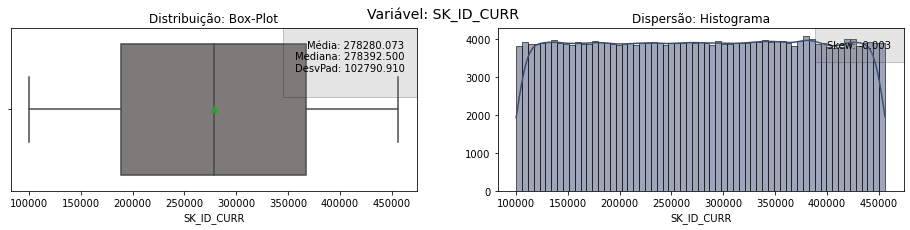

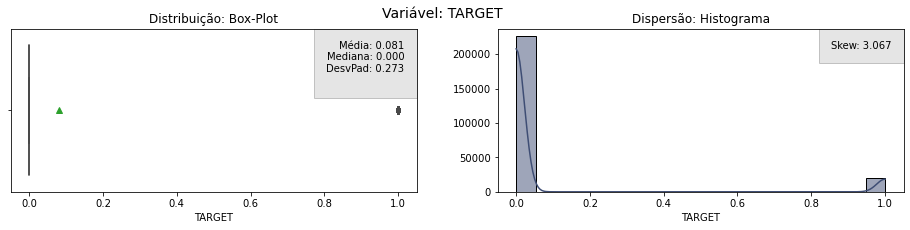

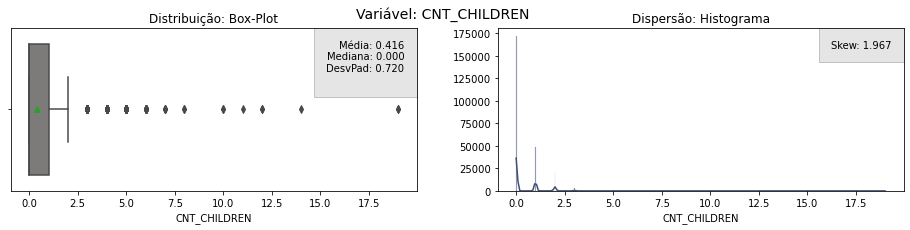

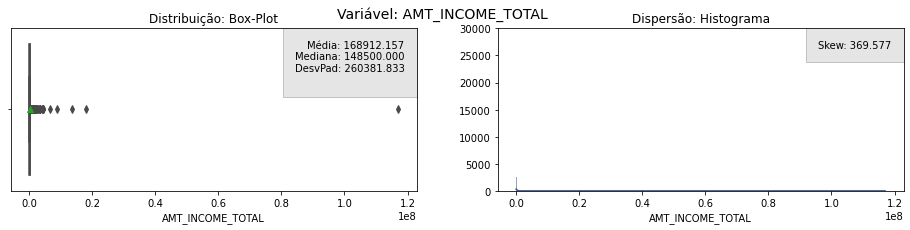

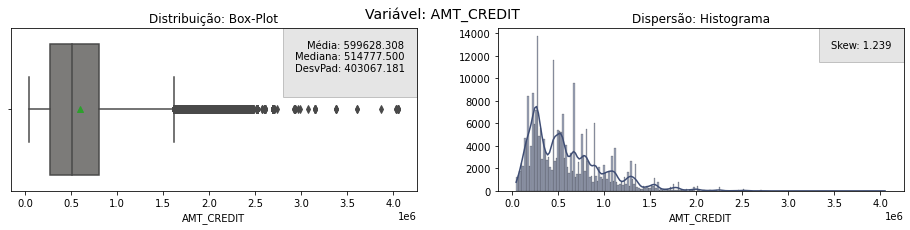

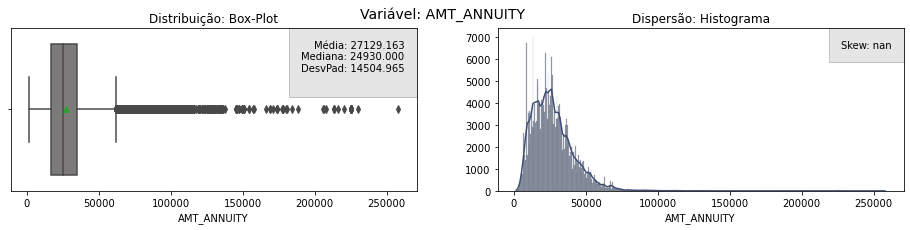

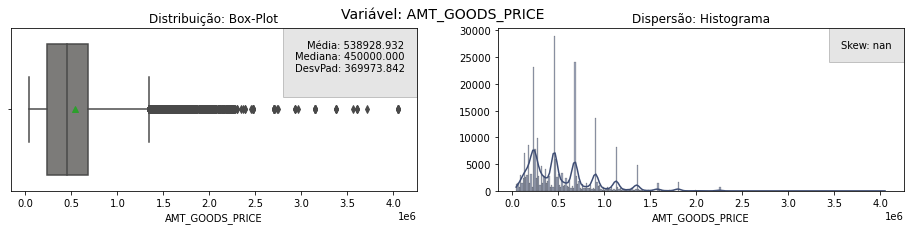

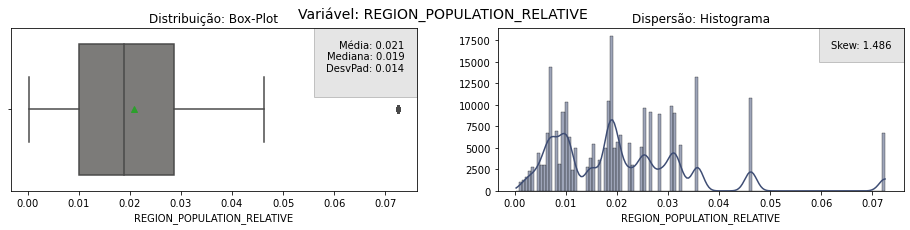

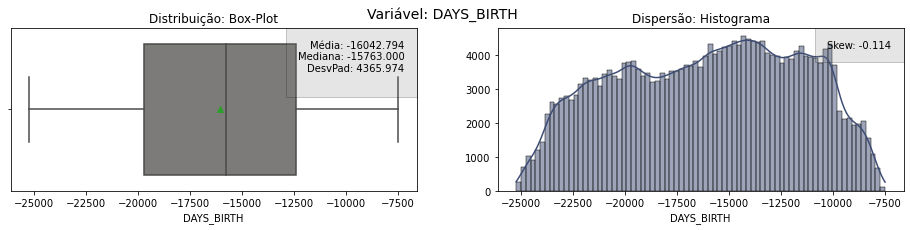

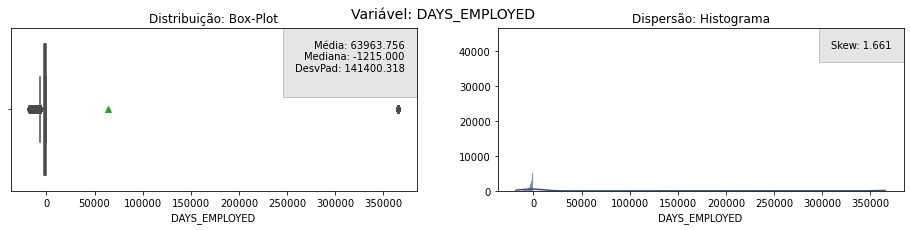

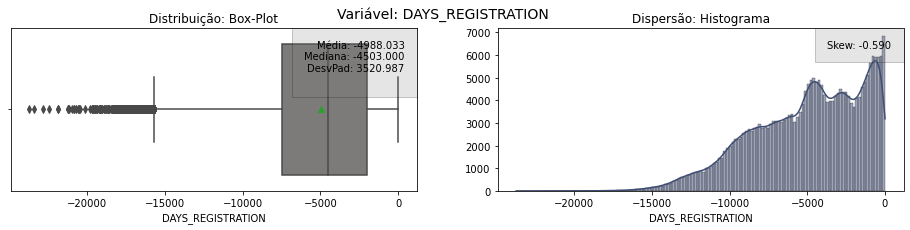

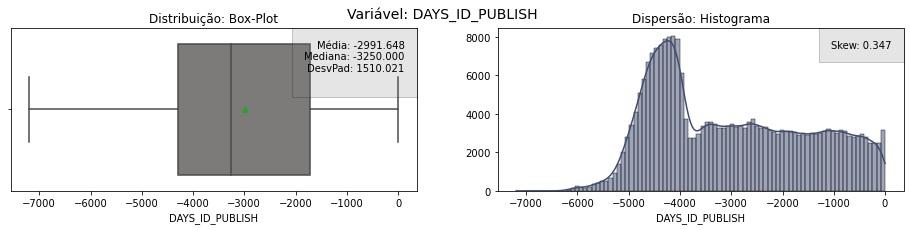

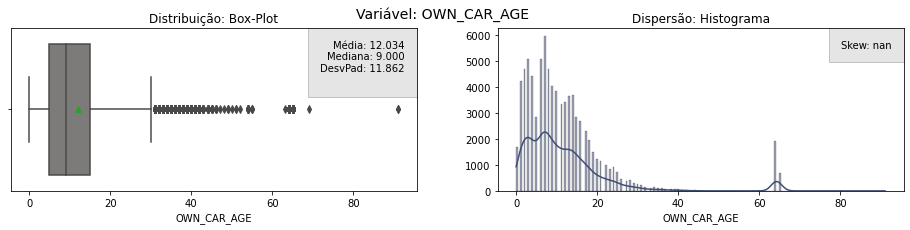

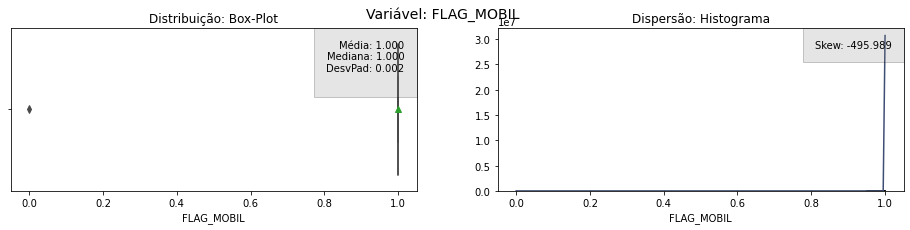

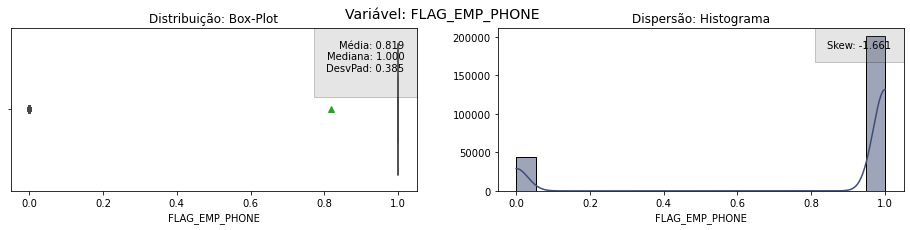

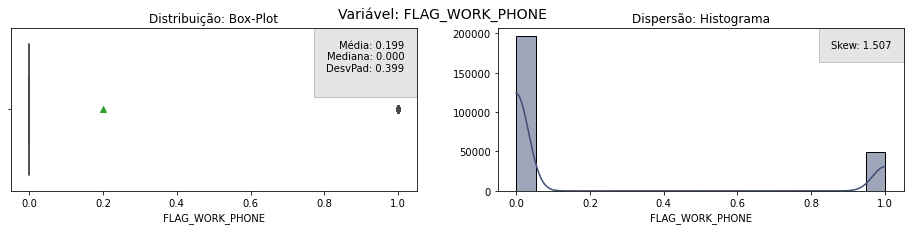

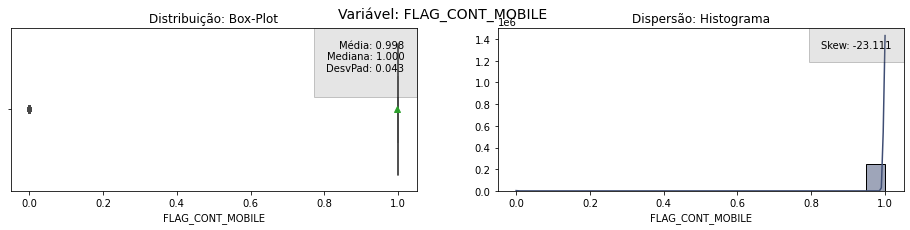

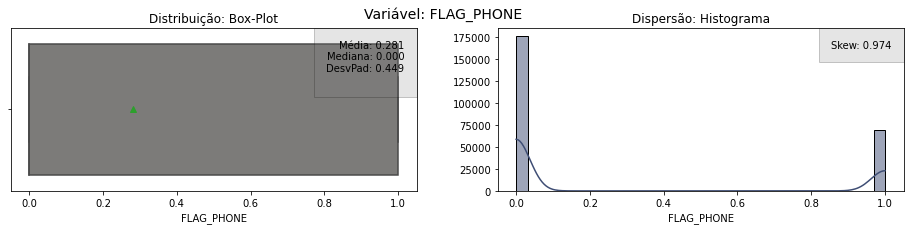

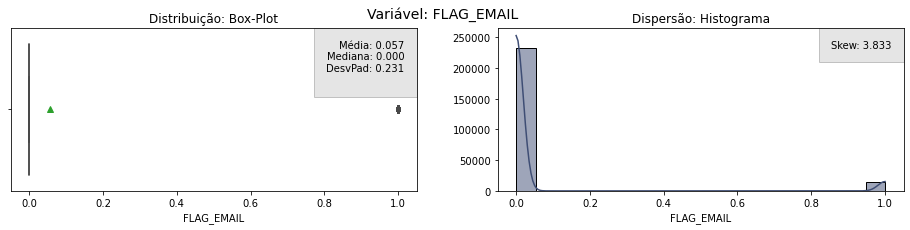

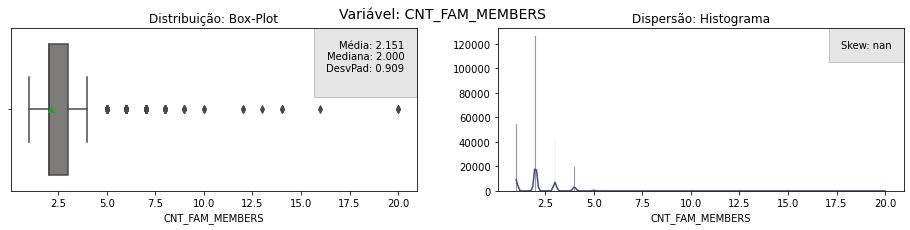

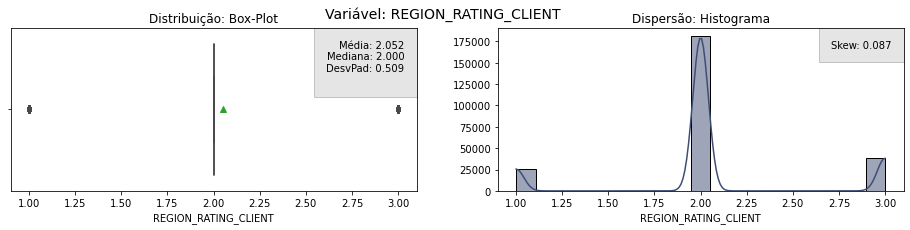

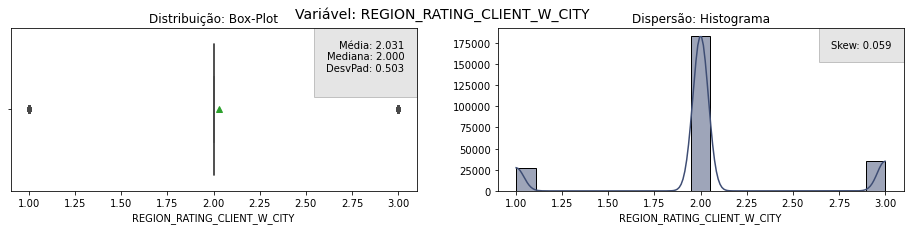

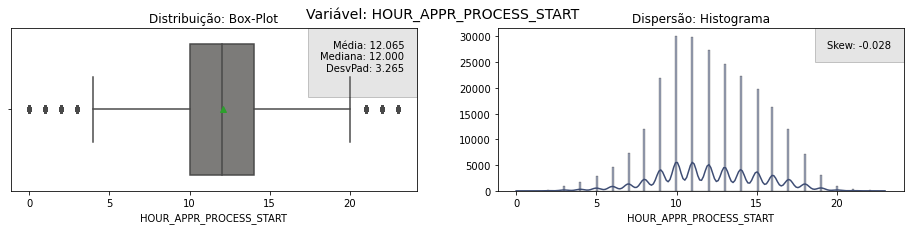

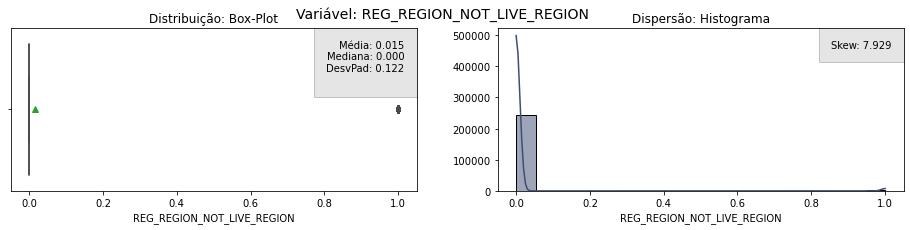

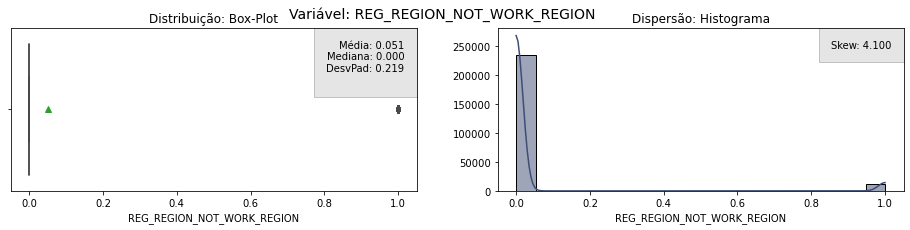

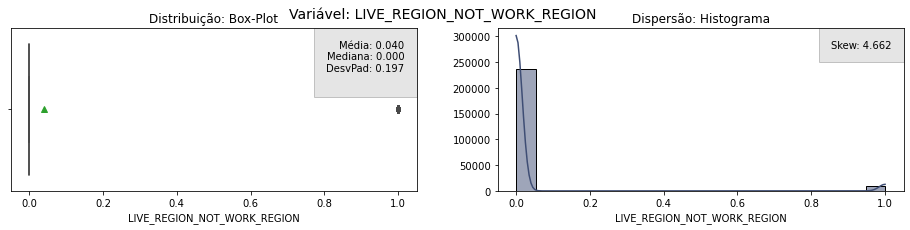

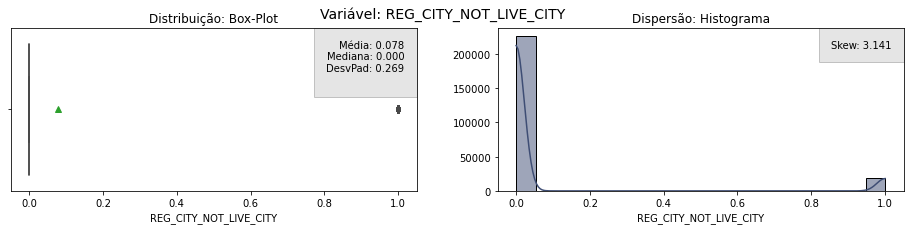

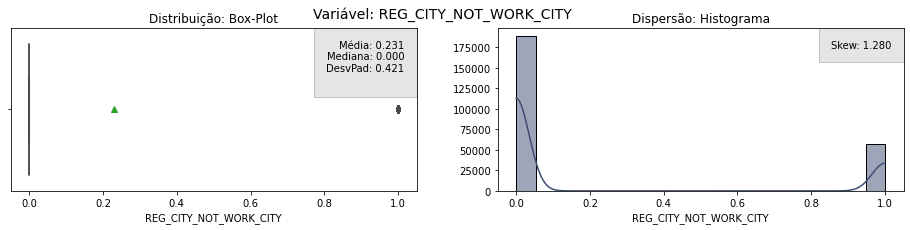

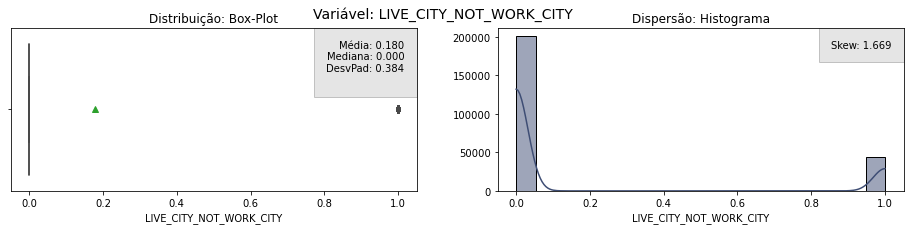

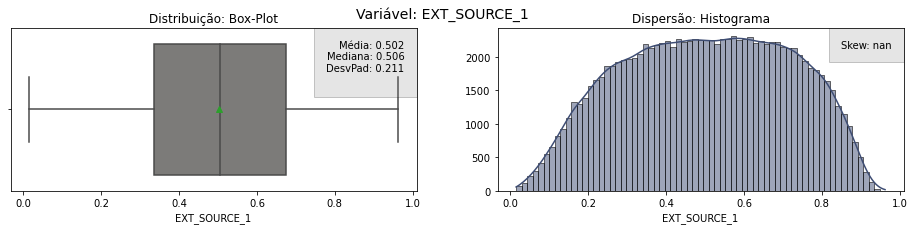

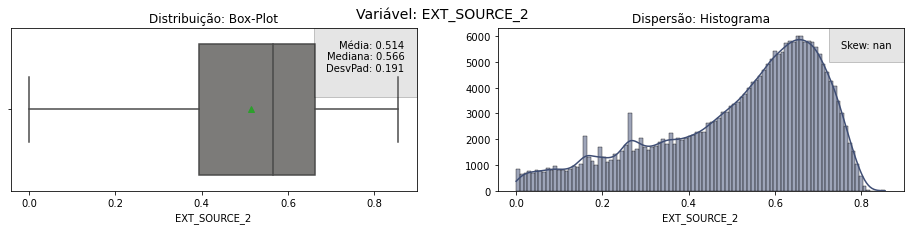

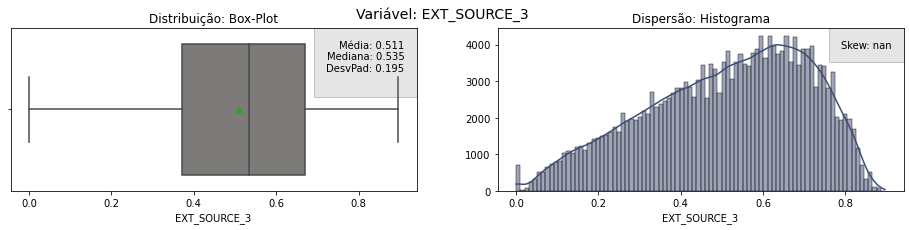

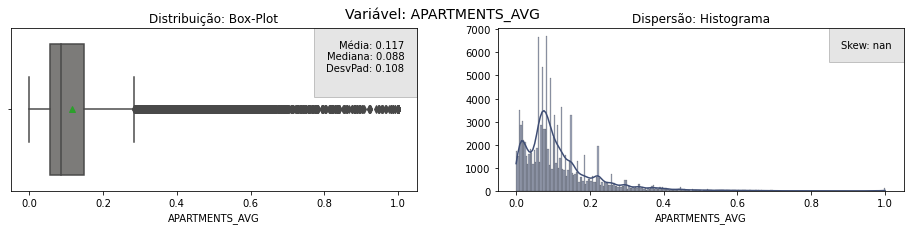

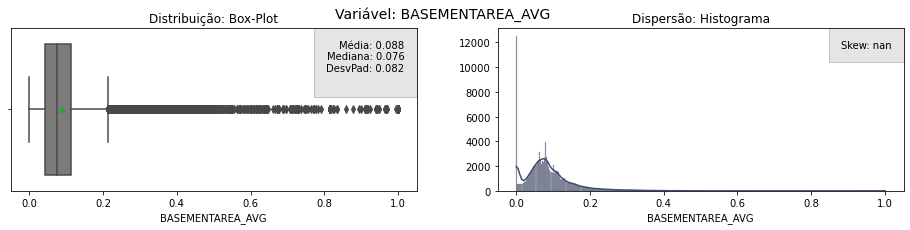

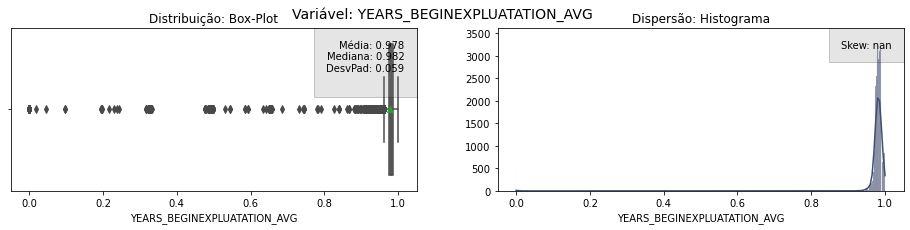

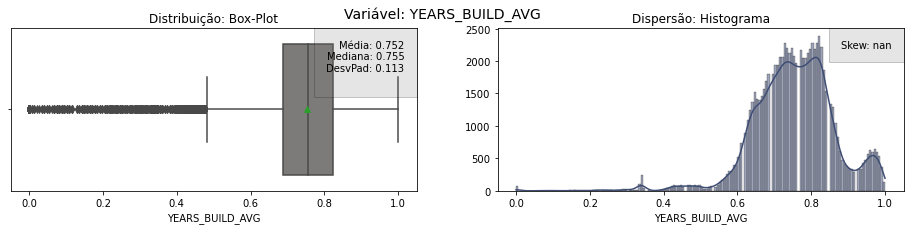

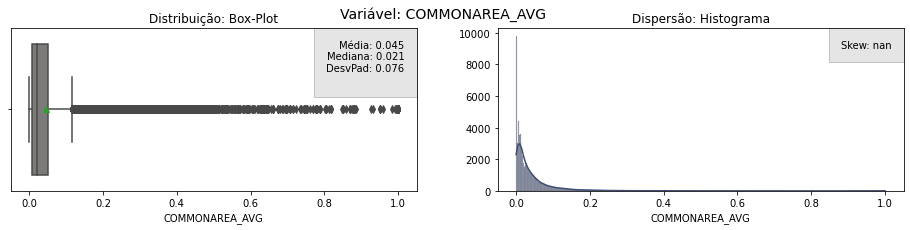

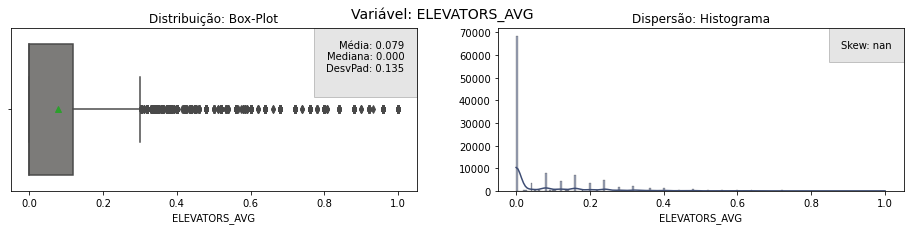

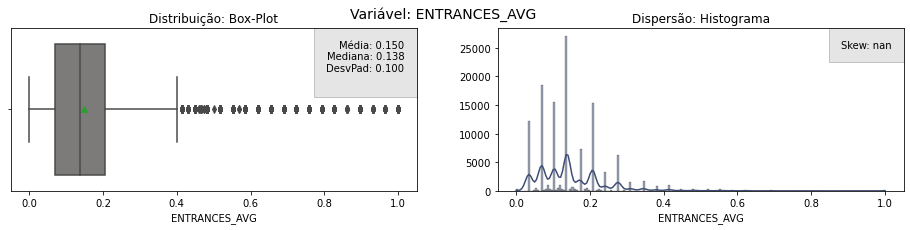

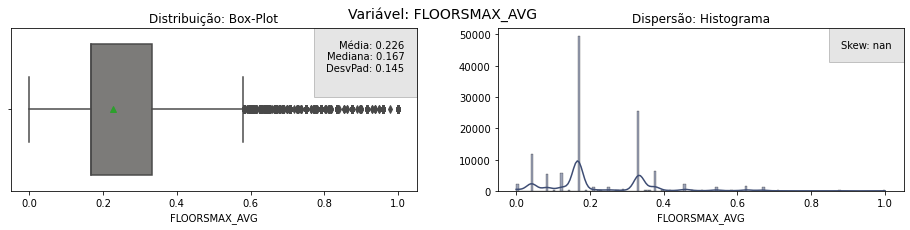

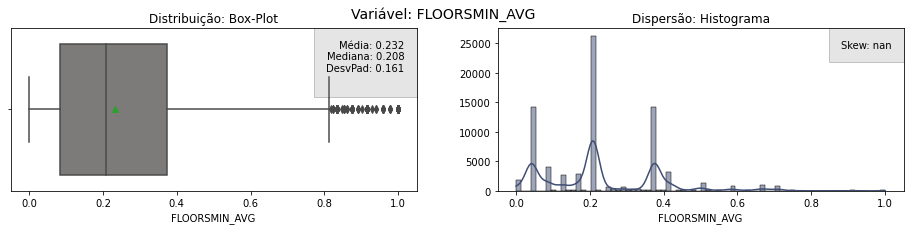

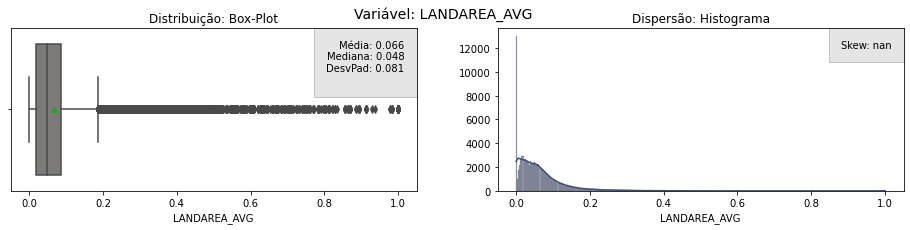

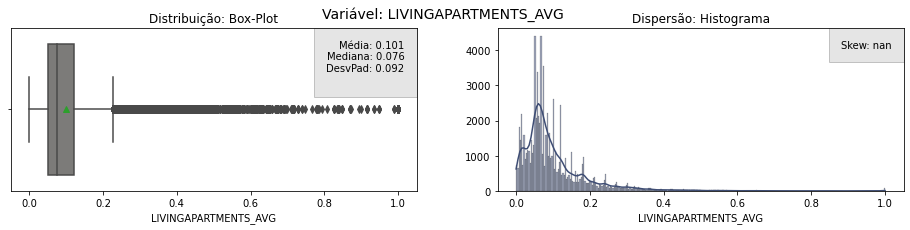

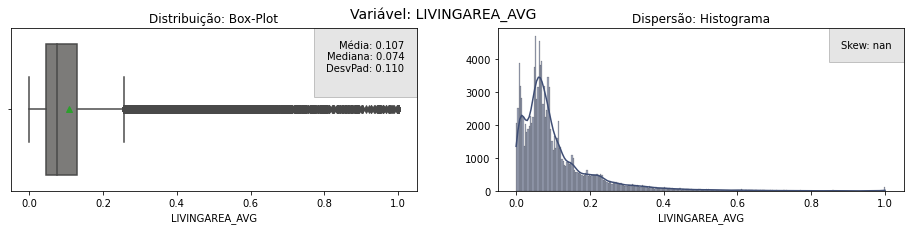

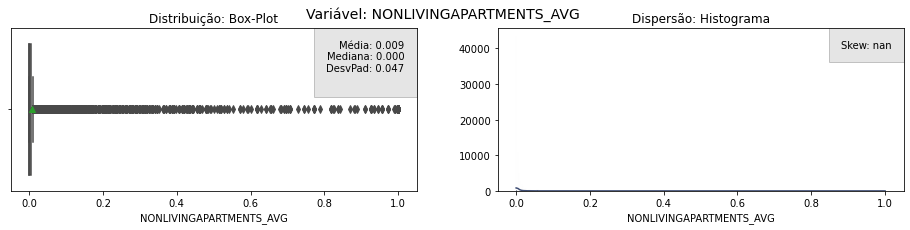

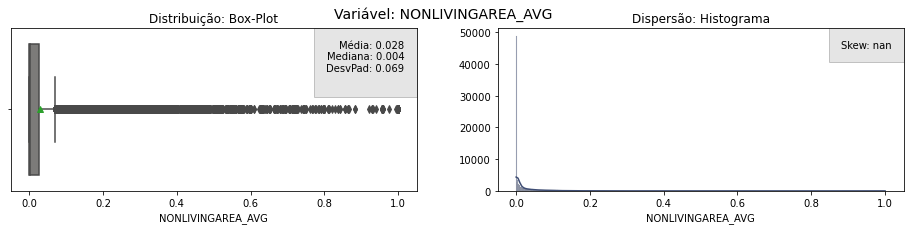

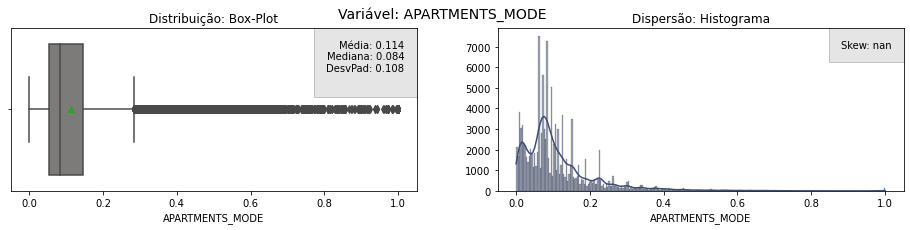

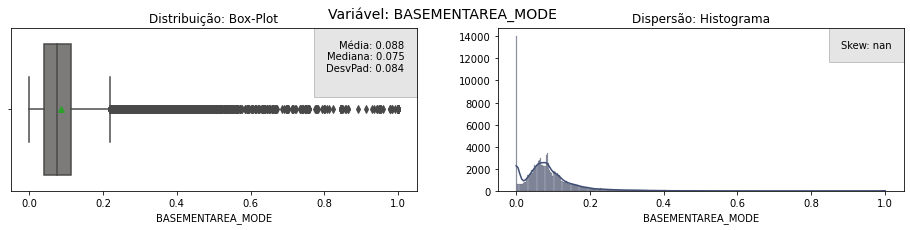

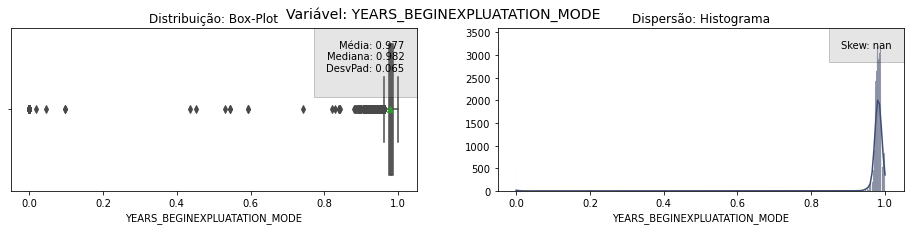

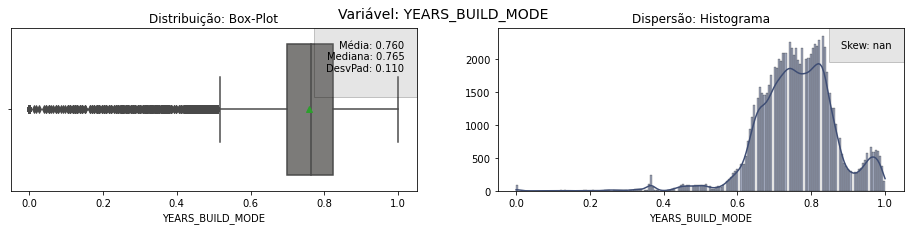

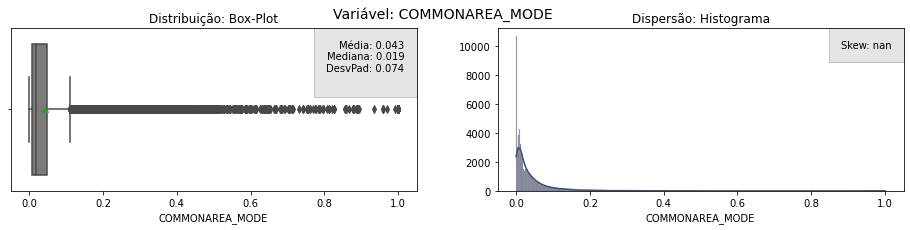

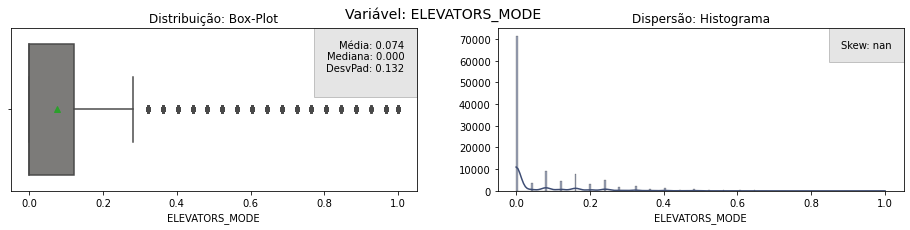

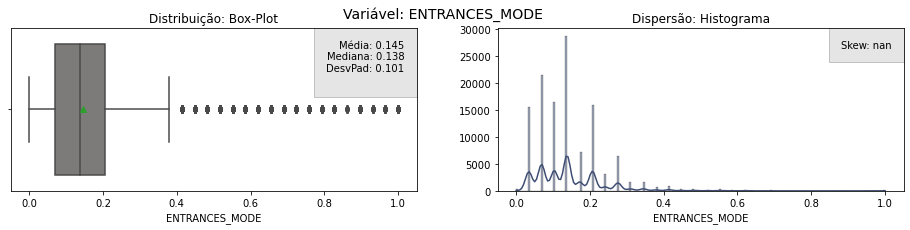

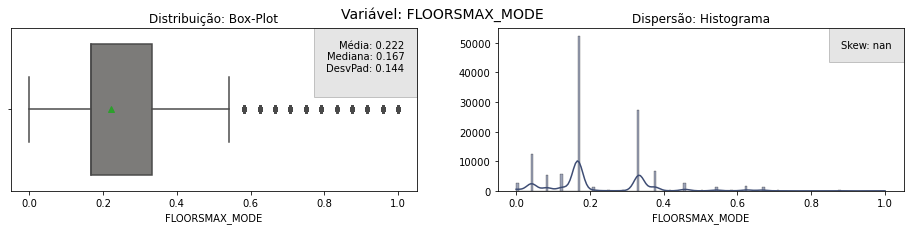

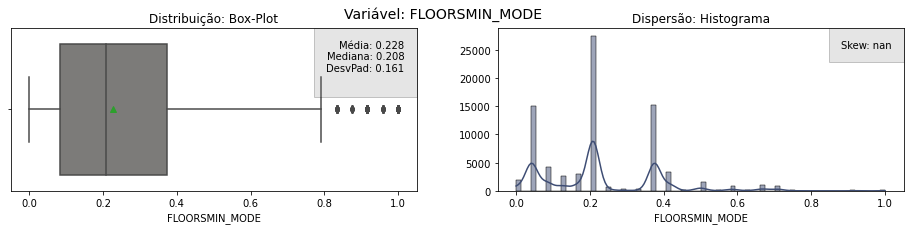

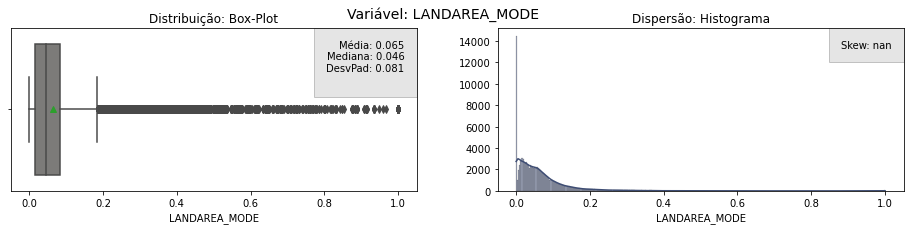

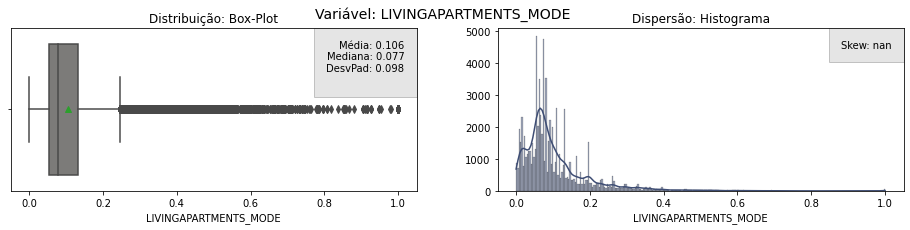

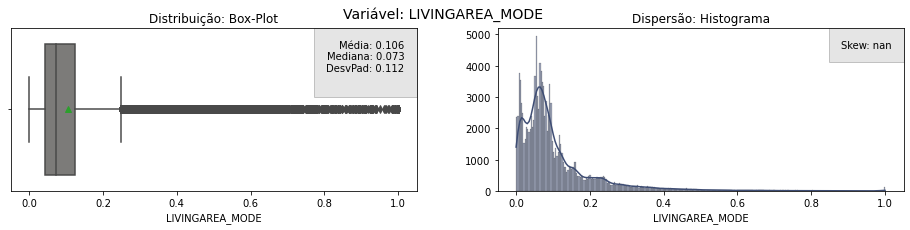

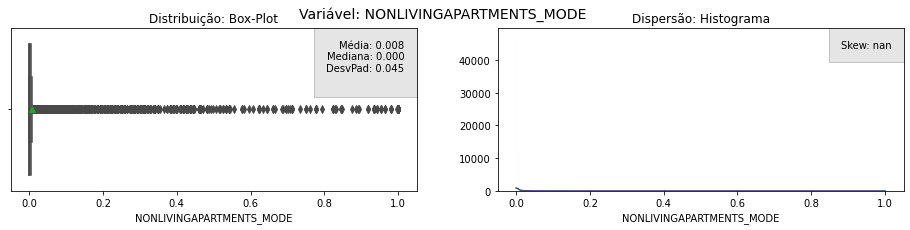

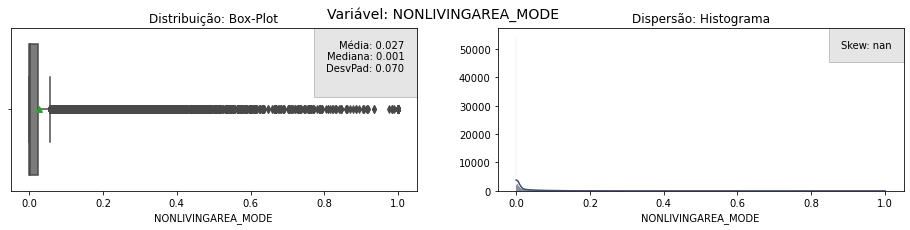

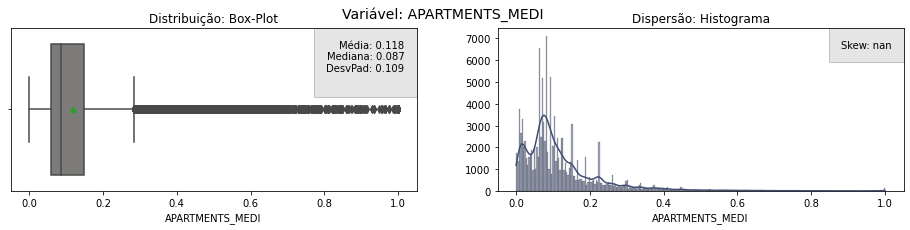

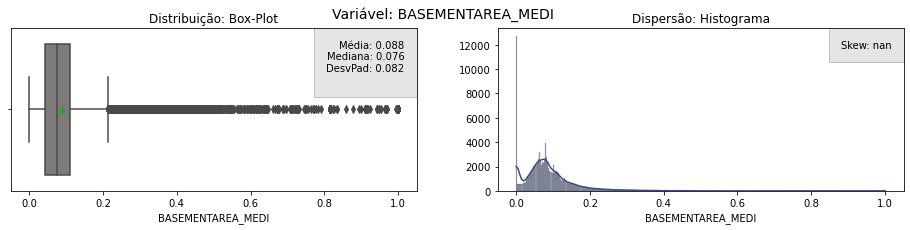

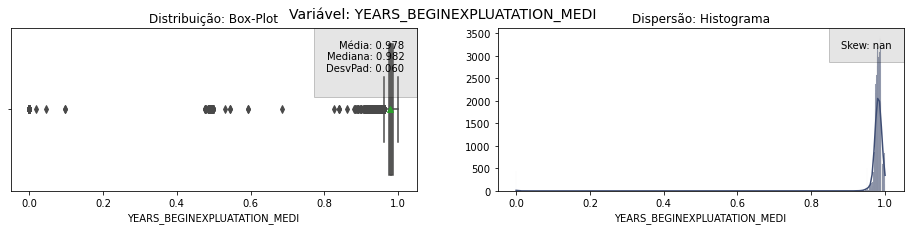

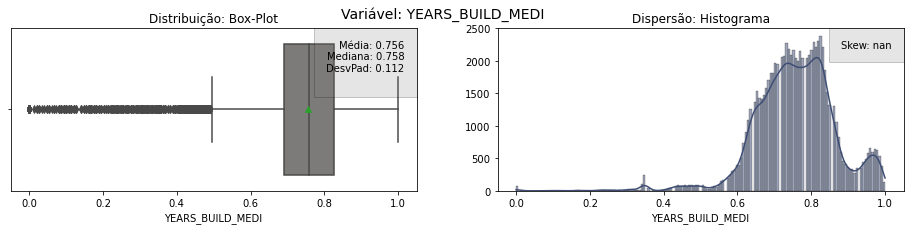

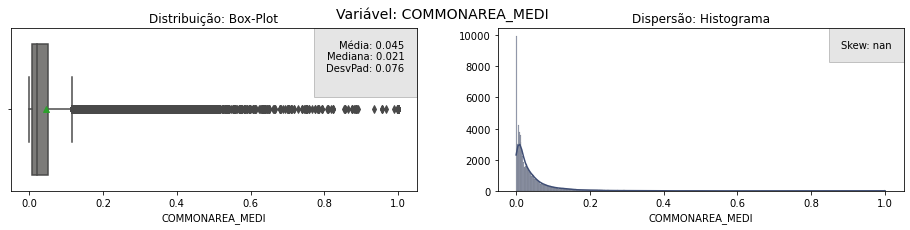

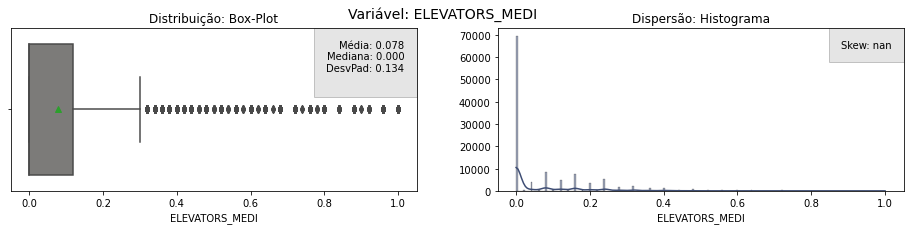

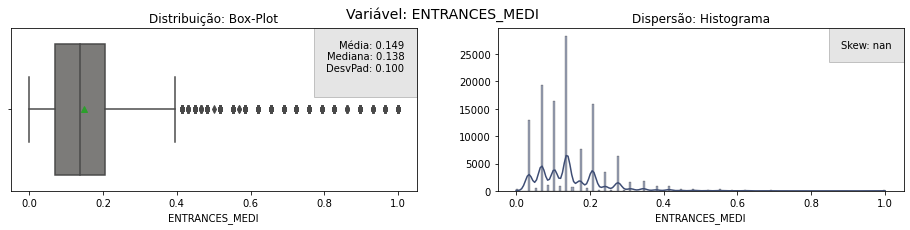

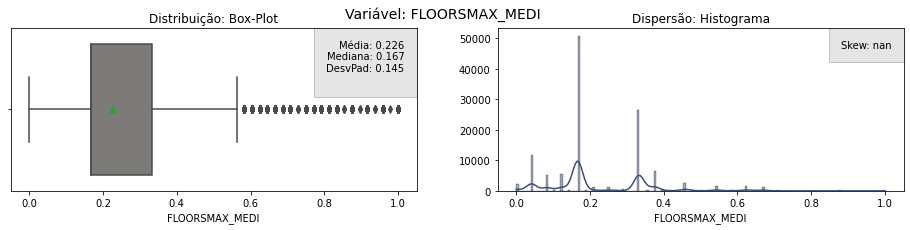

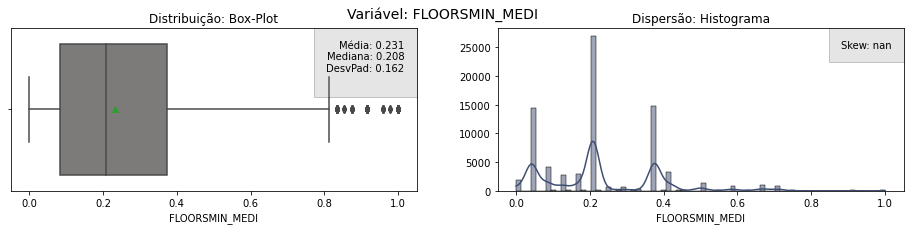

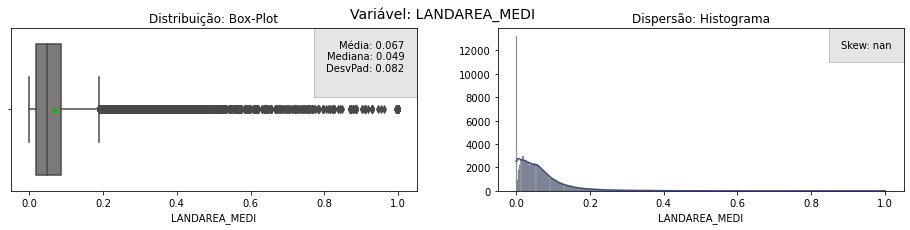

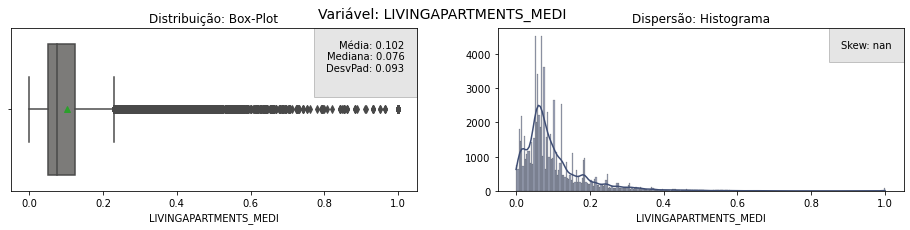

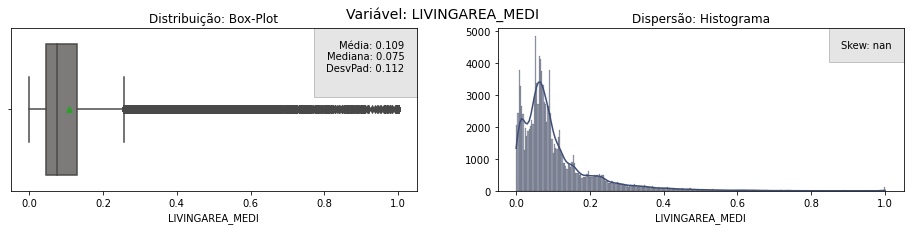

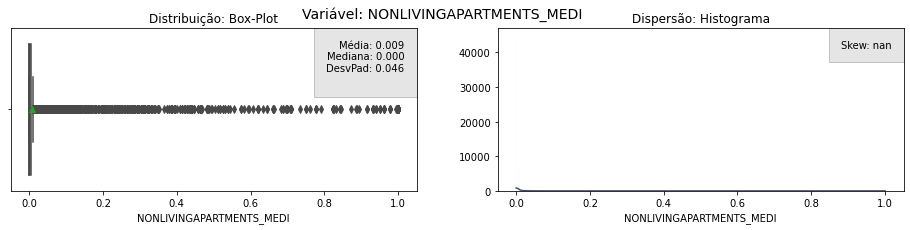

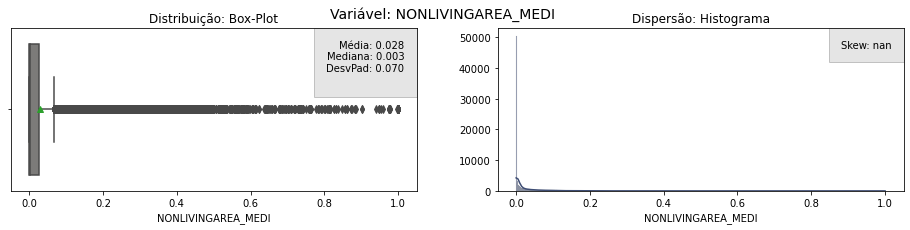

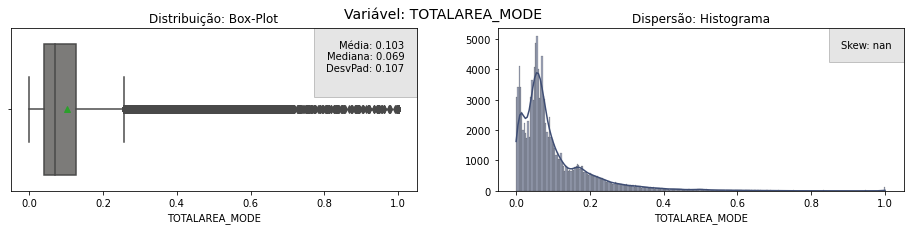

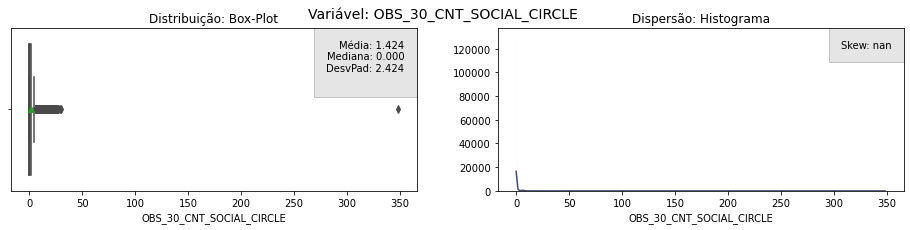

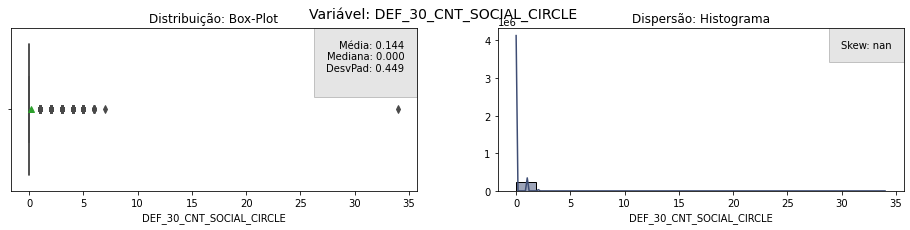

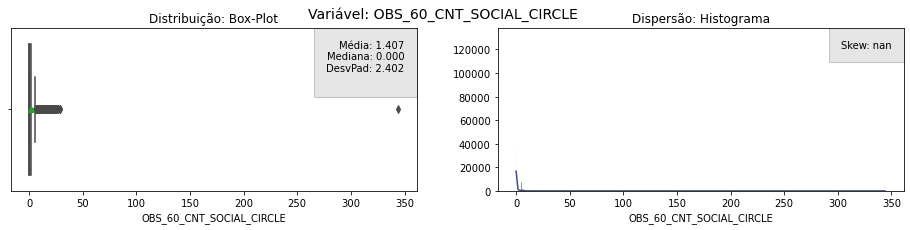

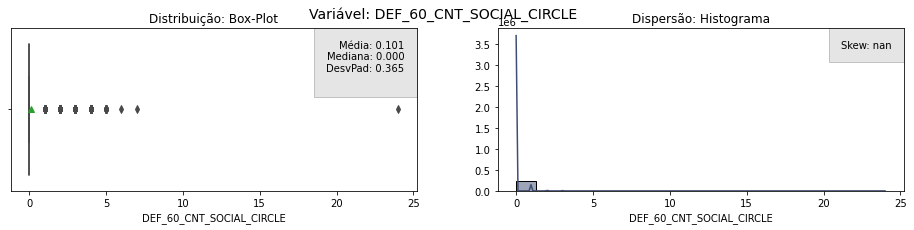

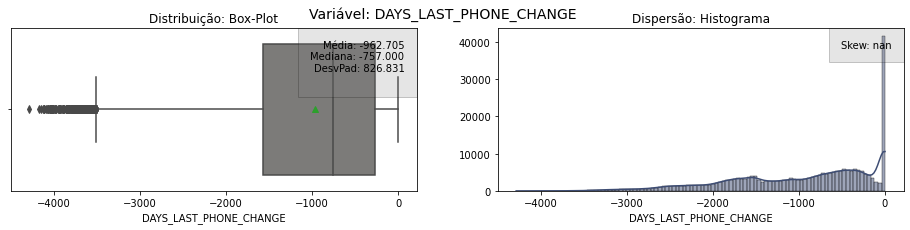

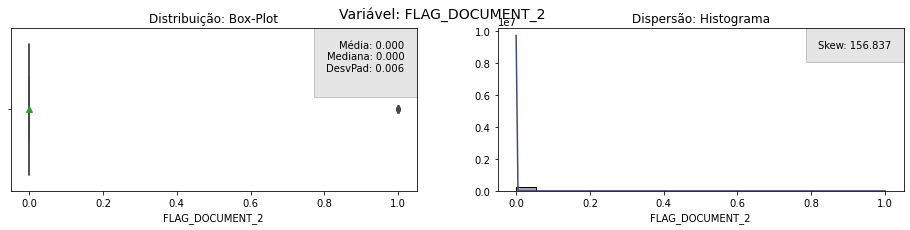

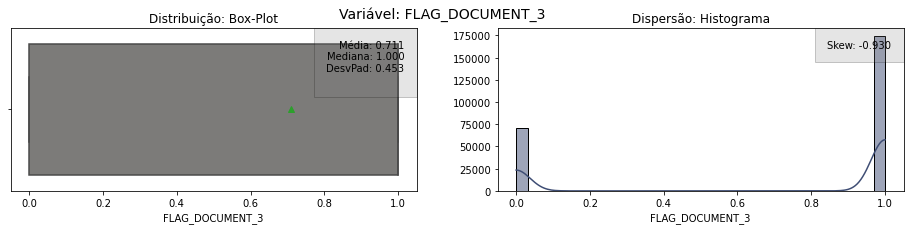

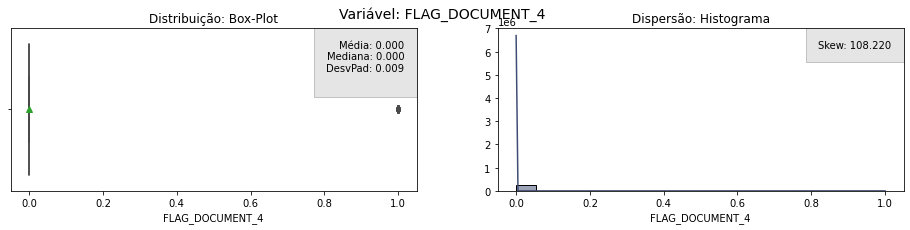

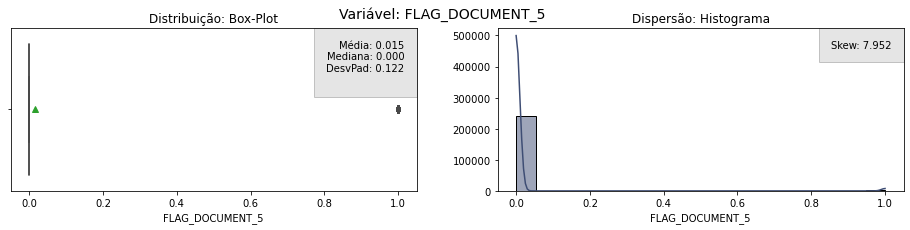

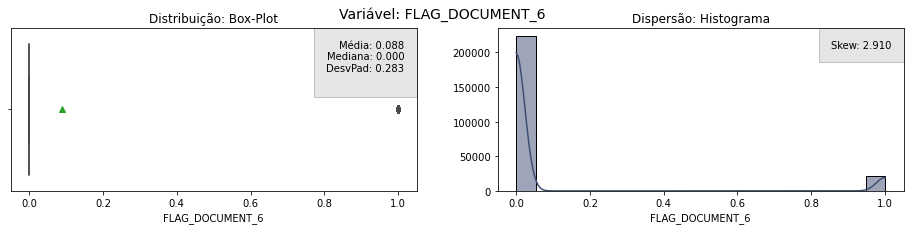

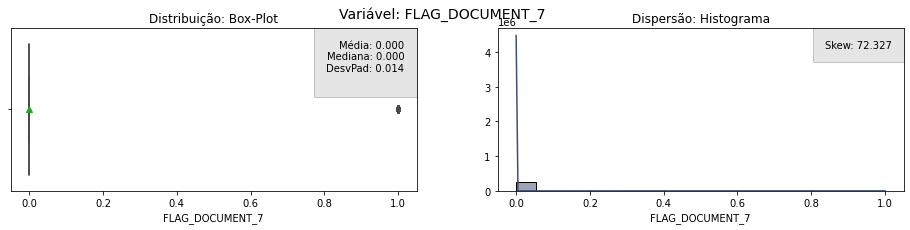

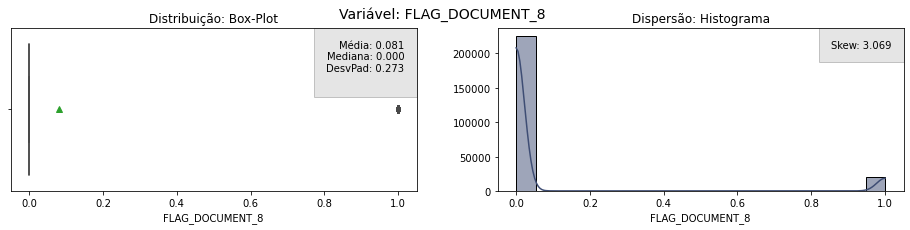

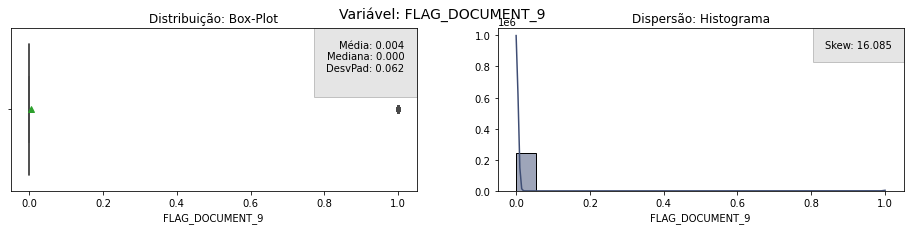

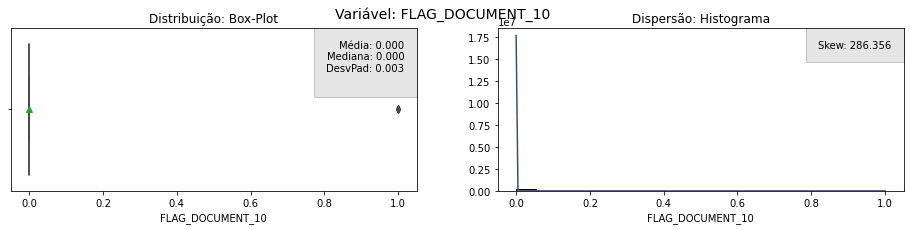

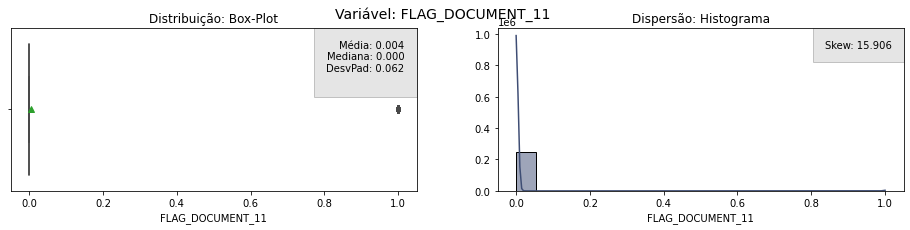

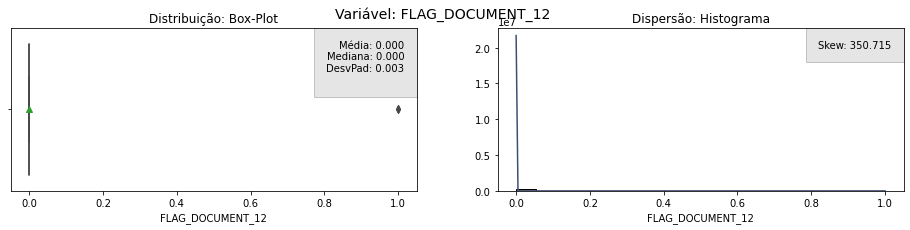

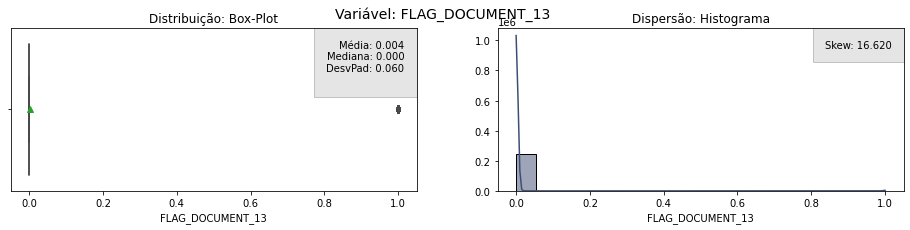

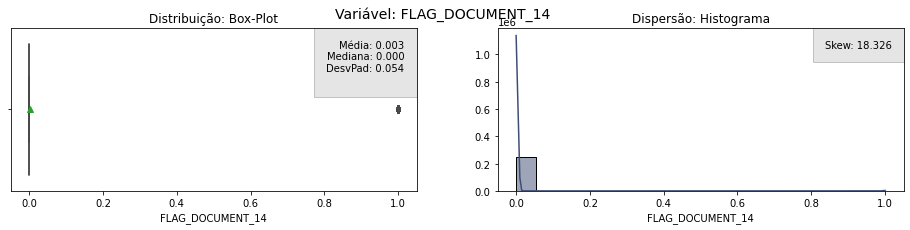

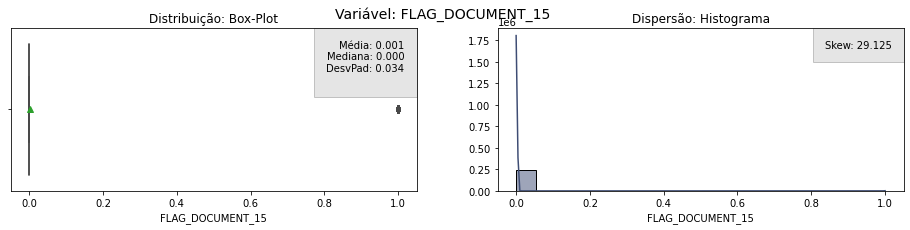

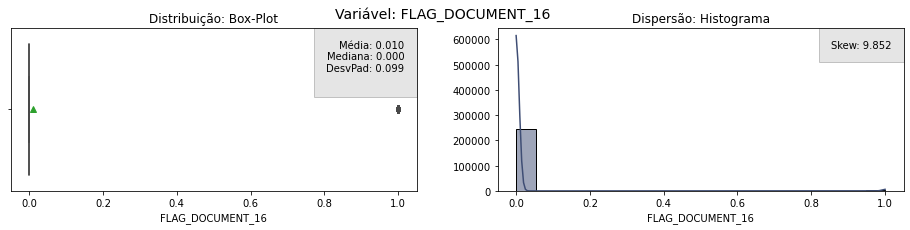

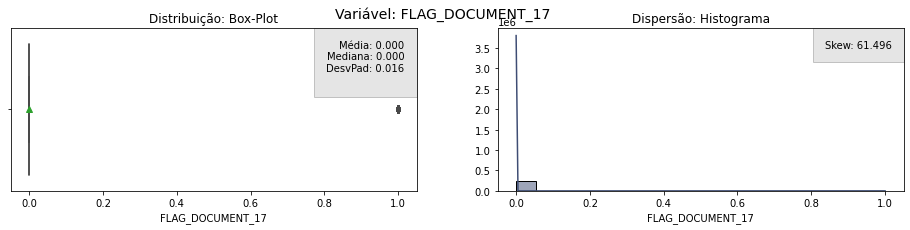

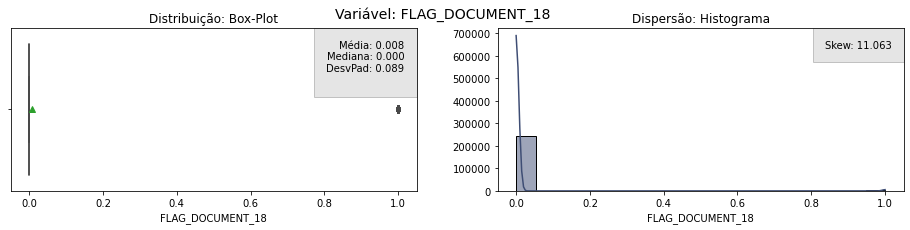

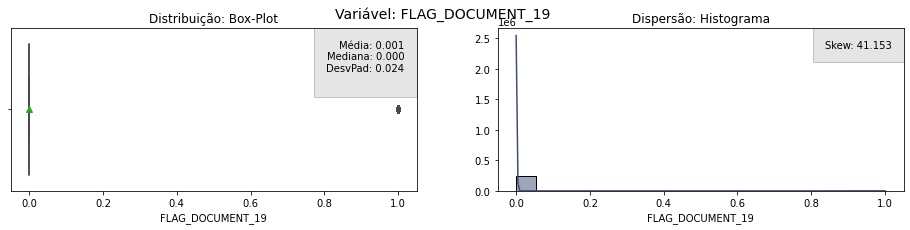

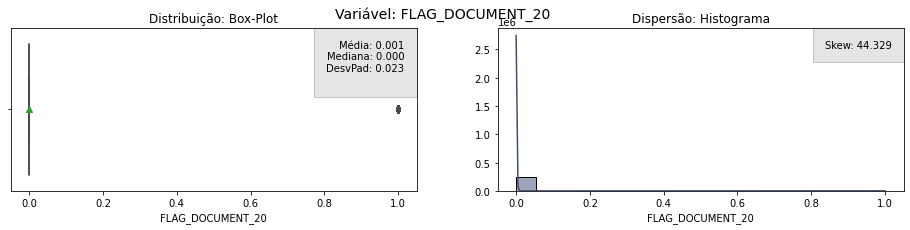

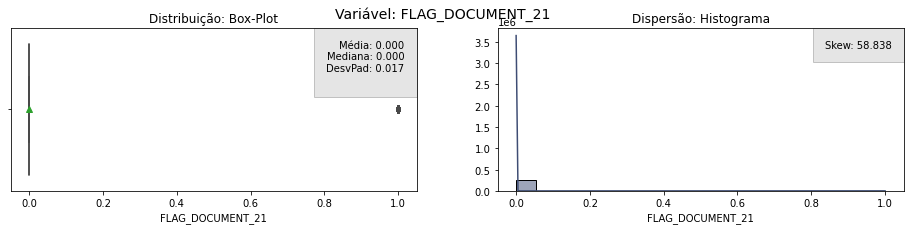

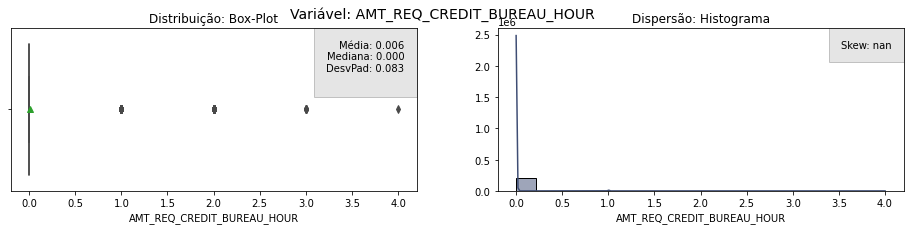

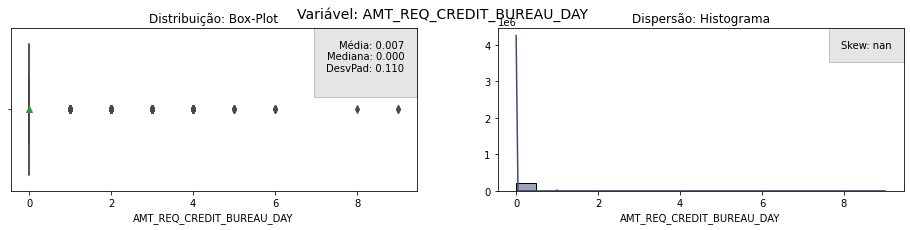

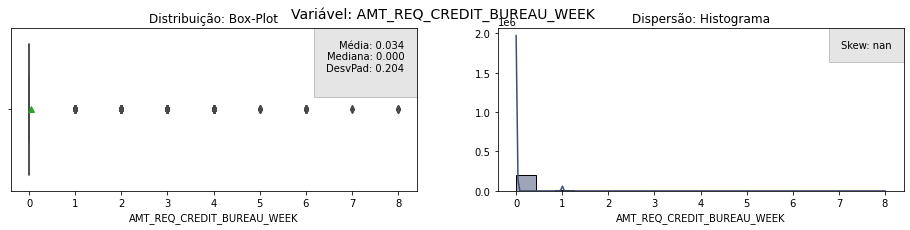

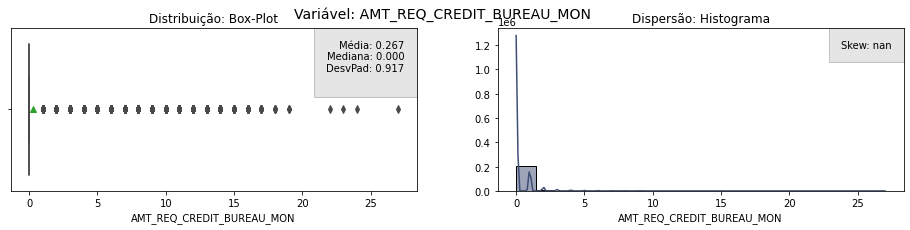

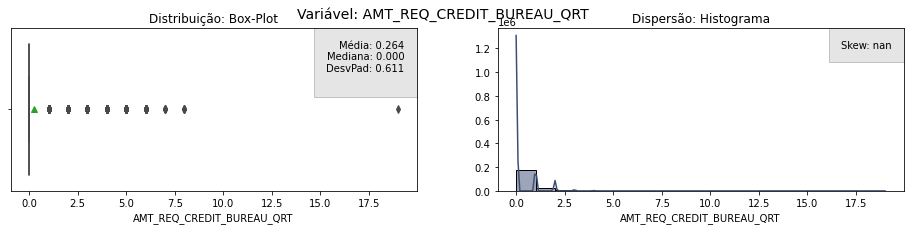

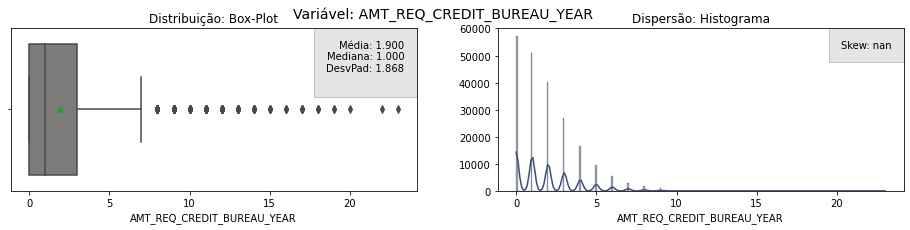

In [19]:
features_num(app_train,app_train.select_dtypes(include=np.number).columns)

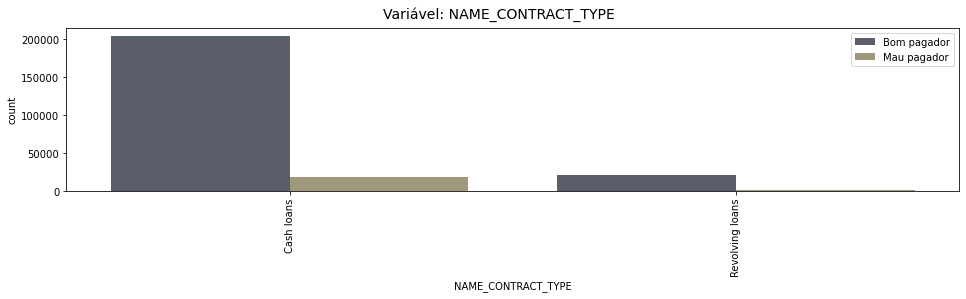

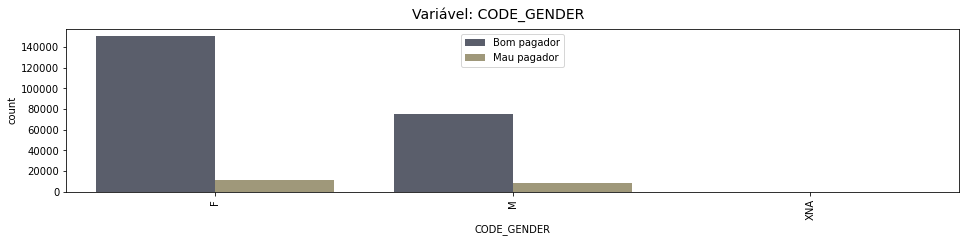

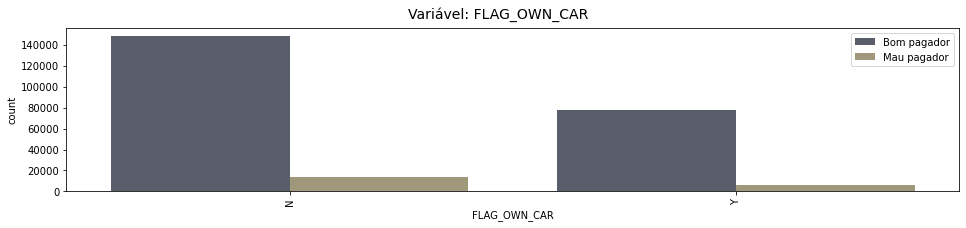

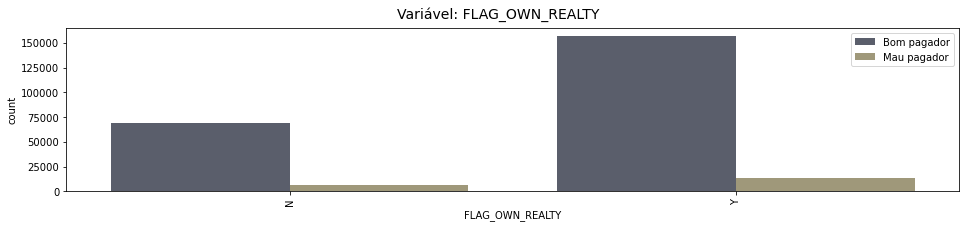

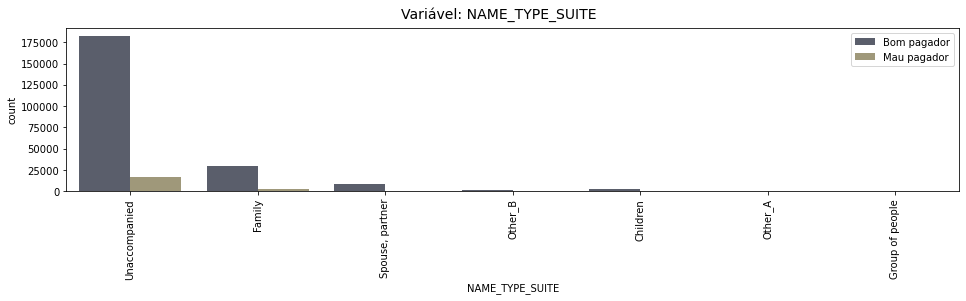

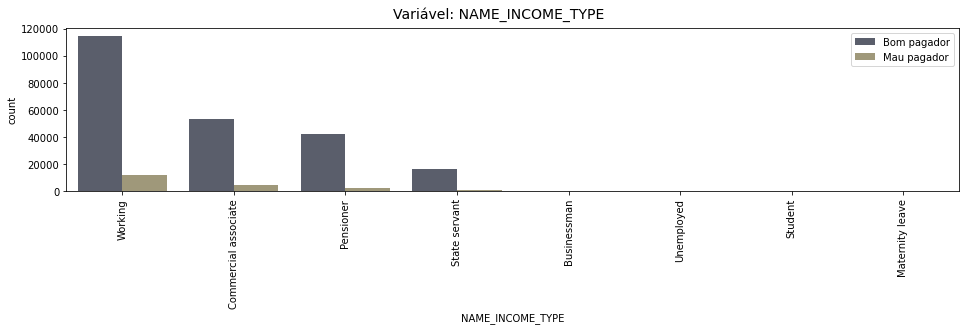

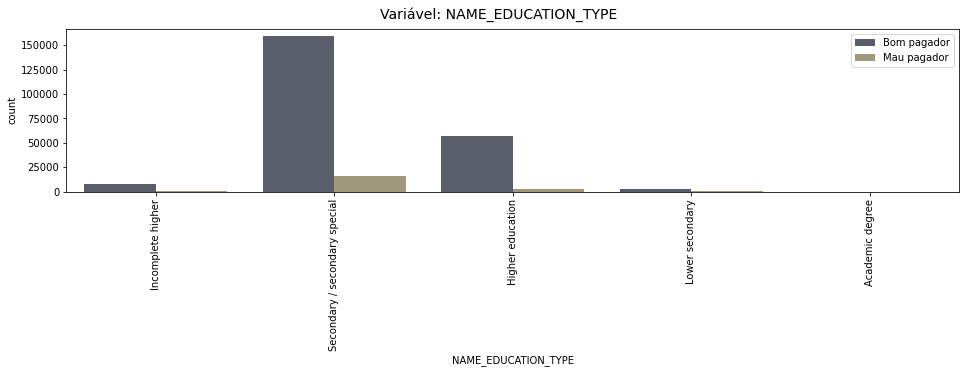

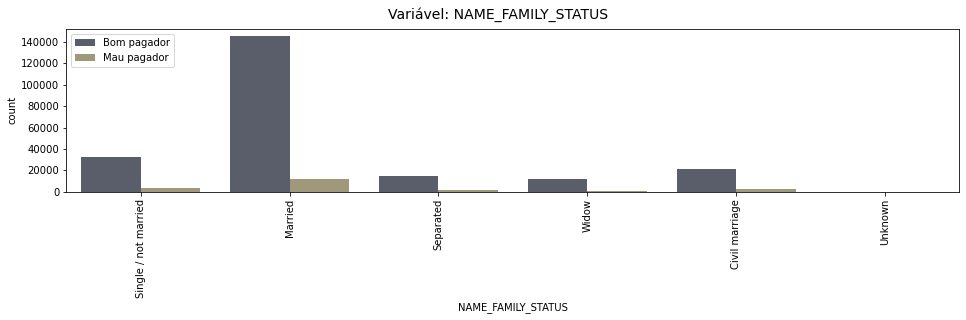

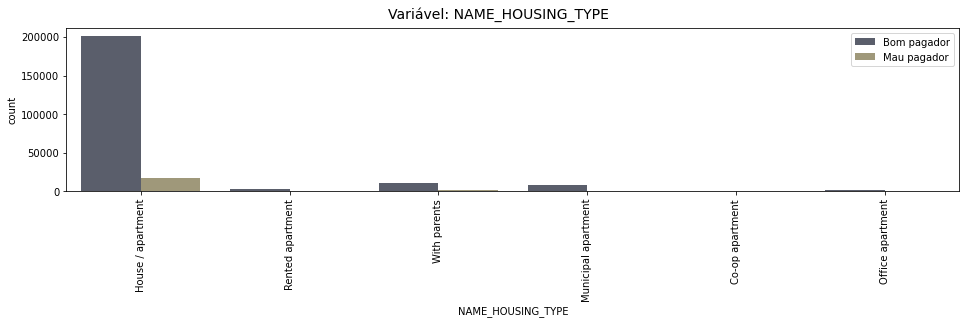

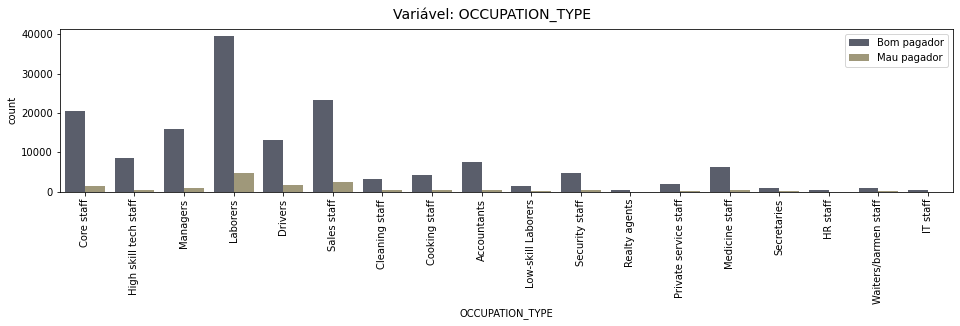

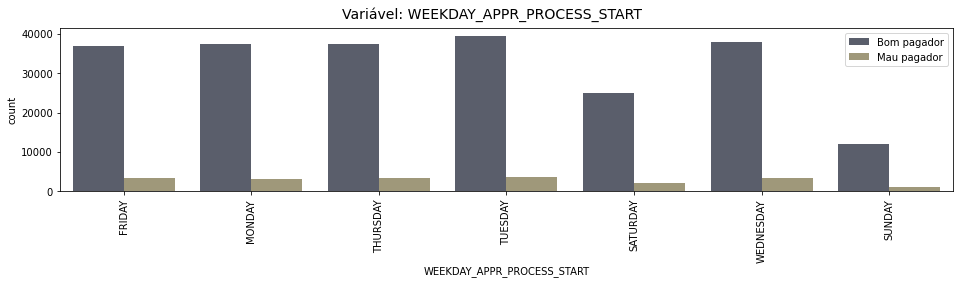

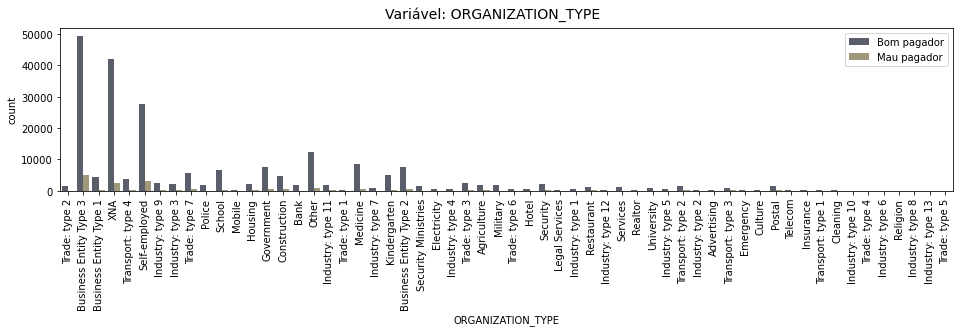

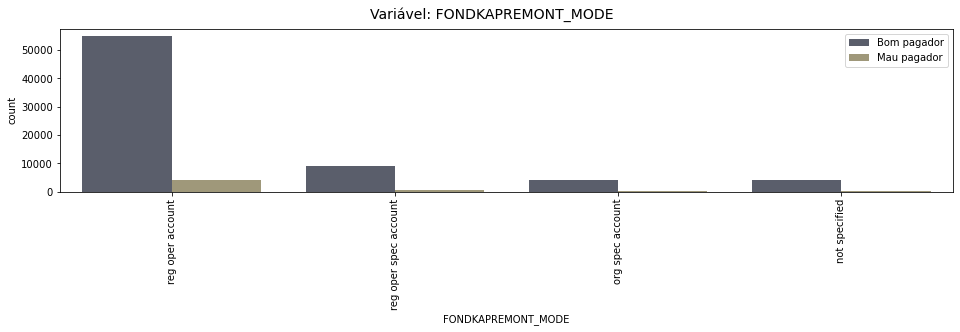

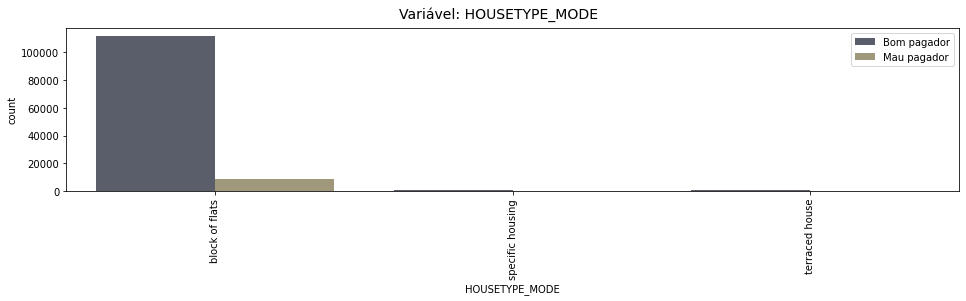

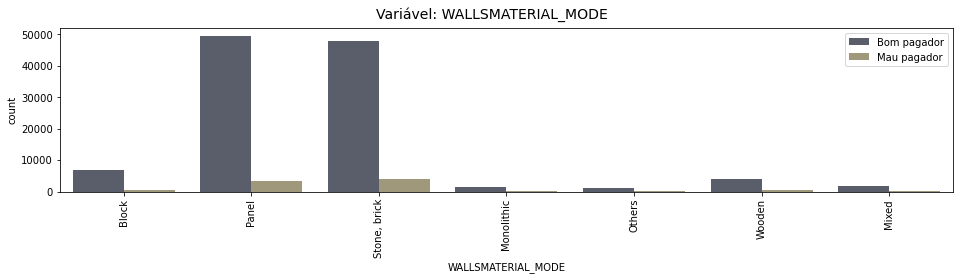

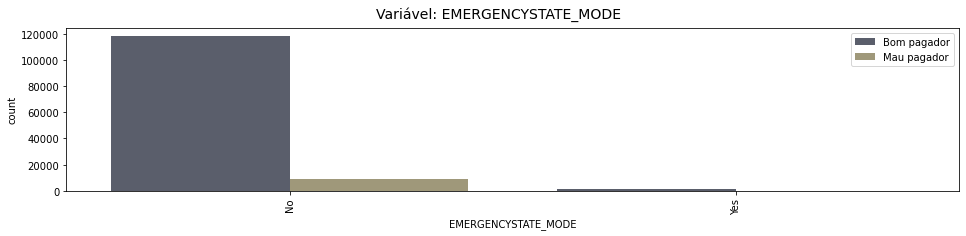

In [20]:
features_cat(app_train,app_train.select_dtypes(exclude=np.number).columns)

As variavéis FLAG_MOBIL,FLAG_DOCUMENT_2 e DAYS_EMPLOYED serão retiradas do modelo, pois
as duas primeiras features apresentam apenas uma única resposta cada, não apresentando nenhuma contribuição para a discrimanação do modelo e terceira feature apresenta dados inconsistentes uma vez que deveria apresentar quantos dias antes do pedido a pessoa começou o emprego atual e, no entanto, apresenta valores de 350.000 dias, que equivalem a quase mil anos. 

In [21]:
app_train['TARGET'].value_counts(normalize=True)*100

0    91.882378
1     8.117622
Name: TARGET, dtype: float64

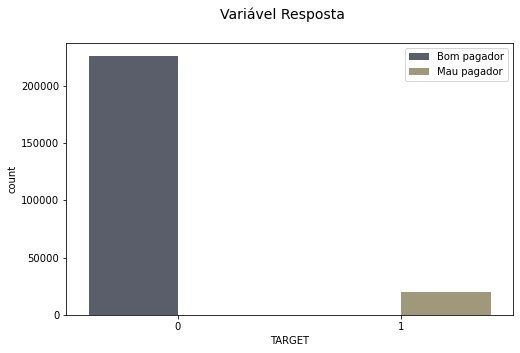

In [22]:
# Vizualizaçao da variável resposta
fig, ax = plt.subplots(figsize=(8, 5))
sns.countplot(data=app_train, x= 'TARGET', hue='TARGET', palette= 'cividis',)
fig.suptitle('Variável Resposta', fontsize=14)
plt.legend(labels=['Bom pagador','Mau pagador'])
plt.show()

O gráfico da variável resposta, onde o bom pagador está representado pelo valor 0 e mau pagador pelo valor 1, nos permite concluir que se trata de uma base de dados desbalanceado e, para evitar que o modelo apenas atribua o valor 0 por ser a resposta mais frequente, deve ser aplicada uma técnica de baleceamento dos dados para auxliar o modelo a se ajustar melhor e possa a distinguir o bom e o mau pagador. 

## Seleção e Criação de Features 

In [23]:
X = app_train.copy().drop(columns=['SK_ID_CURR','TARGET','CODE_GENDER','FLAG_MOBIL','FLAG_DOCUMENT_2','DAYS_EMPLOYED'])
y = app_train.copy()['TARGET']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
fs = SelectKBest(f_classif, k=30) 
X_new = fs.fit_transform(X_train.select_dtypes(include=np.number).fillna(0), y_train) 

In [25]:
importancia = pd.Series(dict(zip(X_train.select_dtypes(include=np.number).columns, fs.scores_)))
importancia = importancia.sort_values(ascending=False).head(30)
importancia

EXT_SOURCE_2                    5043.226242
EXT_SOURCE_3                    2868.662479
DAYS_BIRTH                      1300.440156
EXT_SOURCE_1                     893.640464
REGION_RATING_CLIENT_W_CITY      768.978828
REGION_RATING_CLIENT             708.013611
DAYS_LAST_PHONE_CHANGE           617.095131
DAYS_ID_PUBLISH                  515.885741
REG_CITY_NOT_WORK_CITY           488.105837
FLOORSMAX_AVG                    461.946594
FLOORSMAX_MEDI                   459.356840
FLOORSMAX_MODE                   453.036284
FLAG_EMP_PHONE                   421.377723
REG_CITY_NOT_LIVE_CITY           406.570564
DAYS_REGISTRATION                374.576984
FLAG_DOCUMENT_3                  370.873235
AMT_GOODS_PRICE                  321.284421
TOTALAREA_MODE                   307.816256
YEARS_BEGINEXPLUATATION_MODE     303.449632
YEARS_BEGINEXPLUATATION_AVG      303.107138
YEARS_BEGINEXPLUATATION_MEDI     303.079817
LIVINGAREA_AVG                   302.004805
LIVINGAREA_MEDI                 

In [26]:
importancia

EXT_SOURCE_2                    5043.226242
EXT_SOURCE_3                    2868.662479
DAYS_BIRTH                      1300.440156
EXT_SOURCE_1                     893.640464
REGION_RATING_CLIENT_W_CITY      768.978828
REGION_RATING_CLIENT             708.013611
DAYS_LAST_PHONE_CHANGE           617.095131
DAYS_ID_PUBLISH                  515.885741
REG_CITY_NOT_WORK_CITY           488.105837
FLOORSMAX_AVG                    461.946594
FLOORSMAX_MEDI                   459.356840
FLOORSMAX_MODE                   453.036284
FLAG_EMP_PHONE                   421.377723
REG_CITY_NOT_LIVE_CITY           406.570564
DAYS_REGISTRATION                374.576984
FLAG_DOCUMENT_3                  370.873235
AMT_GOODS_PRICE                  321.284421
TOTALAREA_MODE                   307.816256
YEARS_BEGINEXPLUATATION_MODE     303.449632
YEARS_BEGINEXPLUATATION_AVG      303.107138
YEARS_BEGINEXPLUATATION_MEDI     303.079817
LIVINGAREA_AVG                   302.004805
LIVINGAREA_MEDI                 

In [27]:
# Verificando quais colunas vazias se encontram dentro das 30 features mais importantes selecionadas pelo KBest
reintegradas = []
for feature in colunas_vazias:
    if feature in importancia.head(30):
        reintegradas.append(feature)
reintegradas      

['EXT_SOURCE_1',
 'APARTMENTS_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'TOTALAREA_MODE']

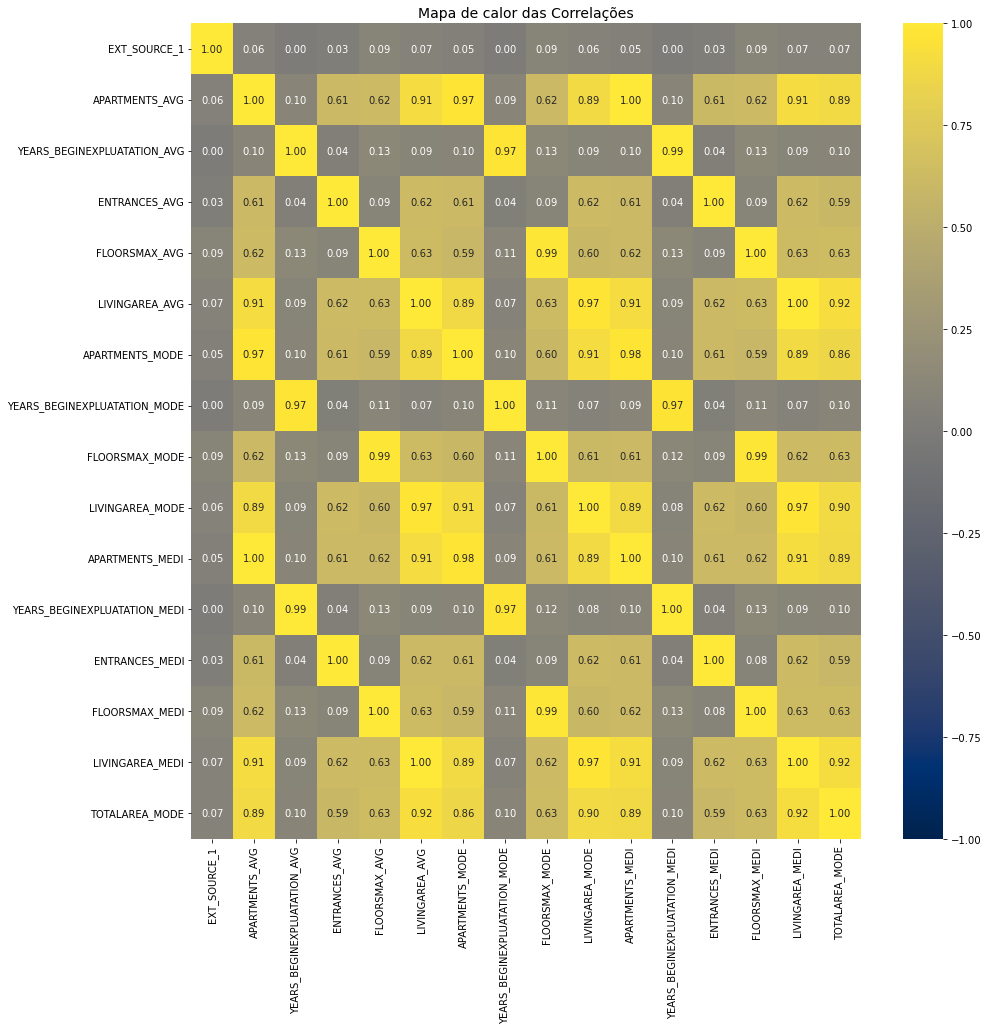

In [28]:
plt.figure(figsize=(15,15))
sns.heatmap(app_train[reintegradas].corr(),vmin=-1,annot=True,fmt='.2f',cmap='cividis')
plt.title('Mapa de calor das Correlações',fontdict= {'fontsize':14},)
plt.show()

Por meio do mapa de calor, feito com as features que estavam com muitos valores faltantes, mas que KBest consideirou como relevantes, nos faz perceber uma forte correlação entre as variáveis terminadas em AVG, MODE e MEDI, portanto reintegraremos as colunas EXT_SOURCE_1, APARTMENTS_AVG,YEARS_BEGINEXPLUATATION_AVG, ENTRANCES_AVG,FLOORSMAX_AVG, LIVINGAREA_AVG e TOTALAREA_MODE para evitar o envio de dados com a mesma representatividade tornando o aprendizado do modelo mais simples e com menos colinearidades.

In [29]:
colunas_selecionadas = importancia.drop(reintegradas[6:-1])
colunas_selecionadas.index

Index(['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'EXT_SOURCE_1',
       'REGION_RATING_CLIENT_W_CITY', 'REGION_RATING_CLIENT',
       'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY',
       'FLOORSMAX_AVG', 'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY',
       'DAYS_REGISTRATION', 'FLAG_DOCUMENT_3', 'AMT_GOODS_PRICE',
       'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'LIVINGAREA_AVG',
       'APARTMENTS_AVG', 'ENTRANCES_AVG', 'REGION_POPULATION_RELATIVE'],
      dtype='object')

In [30]:
# Agrupando por 'SK_ID_CURR' e somando o total de dias de atraso do dataset auxiliar
cash = pos_cash.groupby(by='SK_ID_CURR')[['SK_DPD','SK_DPD_DEF']].sum().reset_index()


In [31]:
# Agrupando por 'SK_ID_CURR' e somando o total de valores das colunas do dataset auxiliar
bc = bureau.groupby(by='SK_ID_CURR')[[
    'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'AMT_CREDIT_MAX_OVERDUE',
    'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT',
    'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE'
]].sum().reset_index()

In [32]:
# Agrupando por 'SK_ID_CURR' e somando o total de valores das colunas do dataset auxiliar e adicionando o limite atual do ultimo mês do cartão de crédito 
cartao = pd.merge(
    credit_card[credit_card['MONTHS_BALANCE'] == -1][[
        'SK_ID_CURR', 'AMT_CREDIT_LIMIT_ACTUAL'
    ]],
    credit_card.groupby(by='SK_ID_CURR')[['SK_DPD',
                                          'SK_DPD_DEF']].sum().reset_index())

In [33]:
# Criando uma coluna com a diferencça de dias entre a data prevista e a data efetiva do pagamento do dataset aulxiliar
ins_pay['DIAS_ATRASADOS'] =ins_pay['DAYS_INSTALMENT'] - ins_pay['DAYS_ENTRY_PAYMENT']
payment = ins_pay.groupby('SK_ID_CURR')[['DIAS_ATRASADOS']].sum().reset_index()

In [34]:
#Retirando as features com maiot quantidade de dados faltantes
df = app_train.copy().drop(colunas_vazias, axis=1)
# Retirando os restante de valores missing no dataset
df = df.dropna()

# Resgastando as features vazias, mas que foram selecionadas pelo KBest como features importantes
df1 = pd.merge(df,
               app_train.copy()[['SK_ID_CURR'] + reintegradas[:6] +
                                reintegradas[-1:]],
               how='left')
df1 = df1[['SK_ID_CURR', 'TARGET'] + colunas_selecionadas.index.to_list() +
          df.select_dtypes(exclude=np.number).columns.to_list()]

#Juntando os dataframe criados ao dataframe principal
df2 = pd.merge(df1, cash, how='left')
df3 = pd.merge(df2, bc, how='left')
df4 = pd.merge(df3, payment, how='left')
df5 = pd.merge(df4, cartao, how='left')

#Separando os dados em treino e validação
X = df5.drop(columns=['SK_ID_CURR', 'TARGET', 'CODE_GENDER'])
y = df5['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)
colunas_teste = X_train.columns

In [35]:
X_train.shape

(156430, 43)

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156430 entries, 93108 to 24770
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   EXT_SOURCE_2                 156430 non-null  float64
 1   EXT_SOURCE_3                 156430 non-null  float64
 2   DAYS_BIRTH                   156430 non-null  int64  
 3   EXT_SOURCE_1                 69585 non-null   float64
 4   REGION_RATING_CLIENT_W_CITY  156430 non-null  int64  
 5   REGION_RATING_CLIENT         156430 non-null  int64  
 6   DAYS_LAST_PHONE_CHANGE       156430 non-null  float64
 7   DAYS_ID_PUBLISH              156430 non-null  int64  
 8   REG_CITY_NOT_WORK_CITY       156430 non-null  int64  
 9   FLOORSMAX_AVG                79192 non-null   float64
 10  FLAG_EMP_PHONE               156430 non-null  int64  
 11  REG_CITY_NOT_LIVE_CITY       156430 non-null  int64  
 12  DAYS_REGISTRATION            156430 non-null  float64
 

Podemos observar na listagem acima que a variável X_train possui valores faltantes apenas nas features que foram criadas dos datasets auxiliares e também das colunas que foram reintegradas na etapa anterior, portanto, devemos nos atentar quanto a estrategia de preenchemento desses dados.

In [37]:
X_train.describe()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,EXT_SOURCE_1,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,DAYS_LAST_PHONE_CHANGE,DAYS_ID_PUBLISH,REG_CITY_NOT_WORK_CITY,FLOORSMAX_AVG,...,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DIAS_ATRASADOS,AMT_CREDIT_LIMIT_ACTUAL
count,156430.000000,156430.000000,156430.000000,69585.000000,156430.000000,156430.000000,156430.000000,156430.000000,156430.000000,79192.000000,...,155599.000000,155599.000000,1.555990e+05,155599.000000,1.555990e+05,1.555990e+05,1.555990e+05,1.555990e+05,149078.000000,1.633000e+04
mean,0.518555,0.510467,-16136.554906,0.508536,2.034802,2.054523,-996.722540,-3050.214172,0.225845,0.225492,...,5.129287,2754.826297,6.971560e+03,0.041793,2.022402e+06,6.689855e+05,2.418749e+04,1.646470e+02,355.565442,2.110065e+05
std,0.188932,0.194825,4295.456542,0.210450,0.497278,0.502810,833.358017,1489.358001,0.418139,0.143589,...,94.515856,12908.217247,9.432716e+04,0.250928,3.656704e+06,1.723704e+06,1.008946e+05,9.563048e+03,542.909945,2.208398e+05
min,0.000001,0.000527,-25201.000000,0.014691,1.000000,1.000000,-4153.000000,-7197.000000,0.000000,0.000000,...,0.000000,-126651.000000,0.000000e+00,0.000000,0.000000e+00,-6.981558e+06,-5.798541e+05,0.000000e+00,-82905.000000,0.000000e+00
25%,0.401109,0.370650,-19722.000000,0.342322,2.000000,2.000000,-1610.000000,-4320.000000,0.000000,0.166700,...,0.000000,-2971.500000,0.000000e+00,0.000000,3.870000e+05,0.000000e+00,0.000000e+00,0.000000e+00,119.000000,4.500000e+04
50%,0.569670,0.535276,-15831.000000,0.514613,2.000000,2.000000,-812.000000,-3332.000000,0.000000,0.166700,...,0.000000,-362.000000,0.000000e+00,0.000000,1.028114e+06,1.977525e+05,0.000000e+00,0.000000e+00,247.000000,1.350000e+05
75%,0.665270,0.667458,-12607.000000,0.681215,2.000000,2.000000,-293.000000,-1815.000000,0.000000,0.333300,...,0.000000,1874.000000,7.200000e+02,0.000000,2.394085e+06,7.018079e+05,0.000000e+00,0.000000e+00,479.000000,2.700000e+05
max,0.855000,0.893976,-7676.000000,0.962693,3.000000,3.000000,0.000000,0.000000,1.000000,1.000000,...,3429.000000,214193.000000,1.314453e+07,9.000000,4.716225e+08,3.344983e+08,8.129328e+06,1.851210e+06,8517.000000,1.350000e+06


# Criação do modelo

Considerando os valores faltantes da variável X_train, adotaremos a estratégia de substituir os valores faltantes por 0 por dois motivos:

1) Para os valores missing que foram gerados a partir da junção dos dataset auxiliares em que não houveram correspondência de SK_ID_CURR, o 0 serve como forma de representação de que não há informações para aquele determinado SK_ID_CURR, ao invés de atribuir um valor como a média por exemplo, e acabar envienzando o modelo.

2) Para as colunas que foram resgatadas, segundo informações do arquivo HomeCredit_columns_description e observado na tabela acima, consta que os valores estão normalizados entre 0 e 1 e, por se tratar da média de um determinado imóvel, talvez faça sentindo pensar que os valores faltantes possam ser de pessoas que não possuem aquele imóvel específico, portanto sendo representado pelo valor 0.


In [38]:
pipe_features_num = Pipeline([('imputer',
                               SimpleImputer(strategy='constant',
                                             fill_value=0)),
                              ("min_max", MinMaxScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()

pipe_features_cat = Pipeline([
    ("input_cat", SimpleImputer(
        strategy="constant",
        fill_value="vazio",
    )), ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

features_cat = X_train.select_dtypes(exclude=np.number).columns.tolist()

pre_processador = ColumnTransformer(
    [("transf_cat", pipe_features_cat, features_cat),
     ("transf_num", pipe_features_num, features_num)], )

sm1 = RandomOverSampler(random_state=42)
X_res, y_res = sm1.fit_resample(X_train, y_train)

pipe_abc = Pipeline([('pre_processador', pre_processador),
                     ("pca", PCA(n_components=0.98)),
                     ('abc', AdaBoostClassifier(random_state=42))])

pipe_abc.fit(X_res, y_res)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='vazio',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
   

Considerando a analise exploratória de dados o modelo a ser adotado será o AdaBoost, um modelo de ensemble, ou seja, a decisão final é tomada em um colegiado de modelos.

O AdaBoost funciana a partir de uma criação de um modelo fraco e a partir dele o algoritimo utiliza os erros do modelo anterior para melhorar o próximo.

Este modelo foi adotado por seu resultado que está 0,02 abaixo nas metricas de classificação recall e roc_auc do modelo  com melhor indicies (Gradient boosting) porém ele trabalha de forma mais eficente com relação ao tempo, performando na metade do tempo.

Foi aplicado neste modelo o PCA, como forma de feature map, fazendo várias componentes (combinações lineares das features originais) que representão a variância completa dos dados sem que seja necessario utilizar todas as variáveis. O objetivo do PCA é melhorar o rendimento do modelo deixando ele mais ágil e evitar colinearidade dos dados. 



# Apresentação dos resultados de validação


Métricas de avaliação de treino:


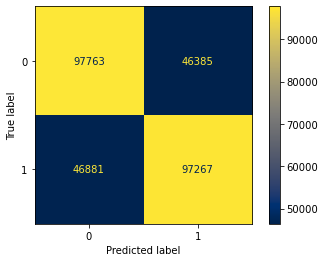

              precision    recall  f1-score   support

           0       0.68      0.68      0.68    144148
           1       0.68      0.67      0.68    144148

    accuracy                           0.68    288296
   macro avg       0.68      0.68      0.68    288296
weighted avg       0.68      0.68      0.68    288296



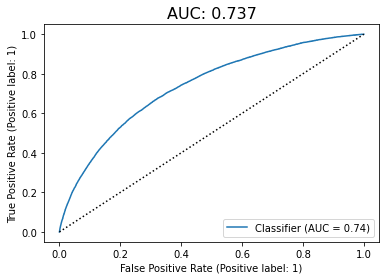


Métricas de avaliação de teste:


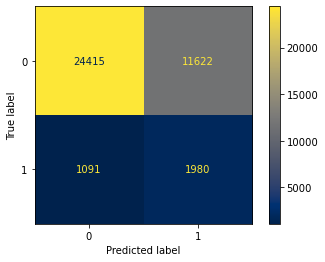

              precision    recall  f1-score   support

           0       0.96      0.68      0.79     36037
           1       0.15      0.64      0.24      3071

    accuracy                           0.67     39108
   macro avg       0.55      0.66      0.52     39108
weighted avg       0.89      0.67      0.75     39108



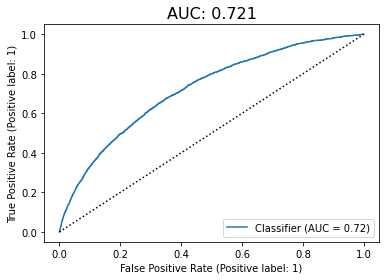

In [39]:
metricas_classificacao(pipe_abc, X_res, X_test, y_res, y_test)

# Ajuste do modelo

In [61]:
#pipe_ab = Pipeline([("pre_processador", pre_processador),
#                    ("pca", PCA(n_components=0.98)),
#                    ("ab", AdaBoostClassifier(random_state=42))])
#
#
#params_grid_ab = {"ab__algorithm" : ['SAMME', 'SAMME.R'],
#                  "ab__n_estimators" : [50, 200, 500]} 
#
#splitter = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
#
#grid_ab = RandomizedSearchCV(estimator=pipe_ab,
#                           param_distributions=params_grid_ab,
#                       scoring="roc_auc",
#                       cv=splitter,
#                       verbose=10)
#
#
#grid_ab.fit(X_res, y_res)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3; 1/6] START ab__algorithm=SAMME, ab__n_estimators=50....................
[CV 1/3; 1/6] END ab__algorithm=SAMME, ab__n_estimators=50;, score=0.724 total time= 1.9min
[CV 2/3; 1/6] START ab__algorithm=SAMME, ab__n_estimators=50....................
[CV 2/3; 1/6] END ab__algorithm=SAMME, ab__n_estimators=50;, score=0.722 total time= 1.9min
[CV 3/3; 1/6] START ab__algorithm=SAMME, ab__n_estimators=50....................
[CV 3/3; 1/6] END ab__algorithm=SAMME, ab__n_estimators=50;, score=0.721 total time= 1.9min
[CV 1/3; 2/6] START ab__algorithm=SAMME, ab__n_estimators=200...................
[CV 1/3; 2/6] END ab__algorithm=SAMME, ab__n_estimators=200;, score=0.741 total time= 7.3min
[CV 2/3; 2/6] START ab__algorithm=SAMME, ab__n_estimators=200...................
[CV 2/3; 2/6] END ab__algorithm=SAMME, ab__n_estimators=200;, score=0.740 total time= 7.3min
[CV 3/3; 2/6] START ab__algorithm=SAMME, ab__n_estimators=200............

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('pre_processador',
                                              ColumnTransformer(transformers=[('transf_cat',
                                                                               Pipeline(steps=[('input_cat',
                                                                                                SimpleImputer(fill_value='vazio',
                                                                                                              strategy='constant')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['NAME_CONTRACT_TYPE',
                                         

{'ab__n_estimators': 500, 'ab__algorithm': 'SAMME.R'}

Métricas de avaliação de treino:


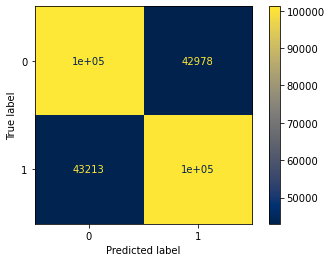

              precision    recall  f1-score   support

           0       0.70      0.70      0.70    144148
           1       0.70      0.70      0.70    144148

    accuracy                           0.70    288296
   macro avg       0.70      0.70      0.70    288296
weighted avg       0.70      0.70      0.70    288296



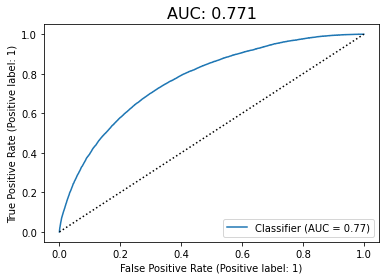


Métricas de avaliação de teste:


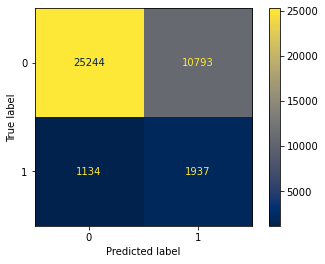

              precision    recall  f1-score   support

           0       0.96      0.70      0.81     36037
           1       0.15      0.63      0.25      3071

    accuracy                           0.70     39108
   macro avg       0.55      0.67      0.53     39108
weighted avg       0.89      0.70      0.76     39108



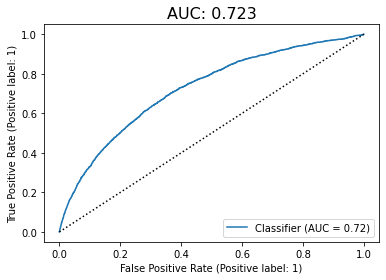

In [63]:
#print(grid_ab.best_params_)
#
#metricas_classificacao(grid_ab, X_res, X_test, y_res, y_test)


Métricas de avaliação de treino:


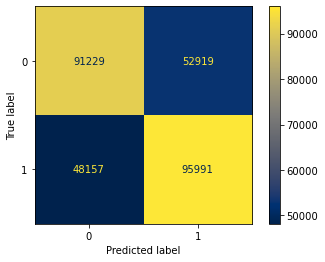

              precision    recall  f1-score   support

           0       0.65      0.63      0.64    144148
           1       0.64      0.67      0.66    144148

    accuracy                           0.65    288296
   macro avg       0.65      0.65      0.65    288296
weighted avg       0.65      0.65      0.65    288296



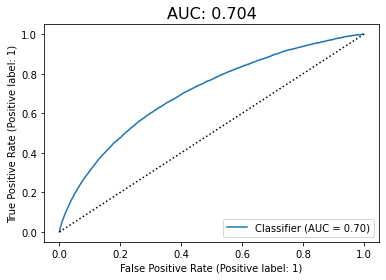


Métricas de avaliação de teste:


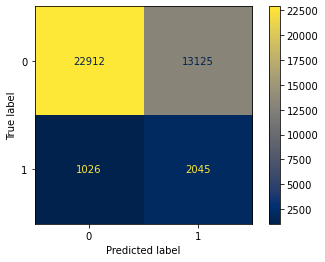

              precision    recall  f1-score   support

           0       0.96      0.64      0.76     36037
           1       0.13      0.67      0.22      3071

    accuracy                           0.64     39108
   macro avg       0.55      0.65      0.49     39108
weighted avg       0.89      0.64      0.72     39108



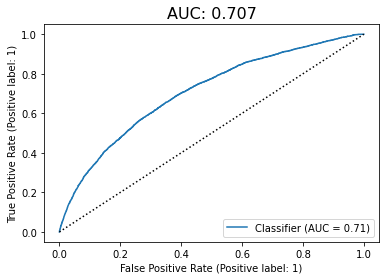

In [40]:
# Pipeline do modelo final
basal = LogisticRegression(l1_ratio = 0.5, random_state=42)


pipe_ab = Pipeline([("pre_processador", pre_processador),
                    ("pca", PCA(n_components=0.98)),
                    ("ab", AdaBoostClassifier(base_estimator=basal,
                                              random_state=42))])


params_grid_ab = {"ab__base_estimator__C" : [0.1, 0.01],
                  "ab__base_estimator__penalty" : ["l1", "l2", "elasticnet"],
                  "ab__n_estimators" : [50, 100, 150]} 

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_ab = RandomizedSearchCV(estimator=pipe_ab,
                           param_distributions=params_grid_ab,
                       scoring="roc_auc",
                       cv=splitter)


grid_ab.fit(X_res, y_res)

metricas_classificacao(grid_ab, X_res, X_test, y_res, y_test)

In [41]:
grid_ab.best_params_

{'ab__n_estimators': 150,
 'ab__base_estimator__penalty': 'l2',
 'ab__base_estimator__C': 0.1}

Ao analisar os modelos criados e o objetivo do projeto, que é distinguir ao máximo os pagadores entre bons e maus,é possível a defesa da ideia de que é mais prejudicial predizer um SK_ID_CURR como bom pagador sendo que na realidade ele é um mau pagador, pois a empresa pode ter prejuizos do que predizer um SK_ID_CURR como mau pagador sendo ele na realidade bom uma vez que a instituição não teve prejuizos apesar de ter deixado ter algum retorno. 

Portanto para corroborar com essa ideia a metrica mais adequada para avaliarmos o modelo é o recall e por isso adotamos as configurações que maximiza essa mertrica em detrerimento da diminuição do ROC_AUC conforme o proposto no enuciado do problema.

In [42]:
basal = LogisticRegression(l1_ratio=0.5, penalty='l2', C=0.1, random_state=42)

pipe_abc1 = Pipeline([('pre_processador', pre_processador),
                      ("pca", PCA(n_components=0.98)),
                      ('abc',
                       AdaBoostClassifier(base_estimator=basal,
                                          n_estimators=150,
                                          random_state=42))])
pipe_abc1.fit(X_res, y_res)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_cat',
                                                  Pipeline(steps=[('input_cat',
                                                                   SimpleImputer(fill_value='vazio',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['NAME_CONTRACT_TYPE',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
   


Métricas de avaliação de treino:


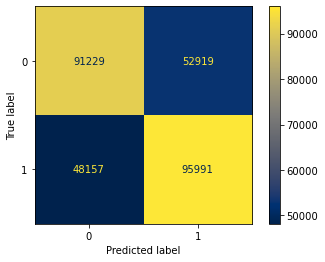

              precision    recall  f1-score   support

           0       0.65      0.63      0.64    144148
           1       0.64      0.67      0.66    144148

    accuracy                           0.65    288296
   macro avg       0.65      0.65      0.65    288296
weighted avg       0.65      0.65      0.65    288296



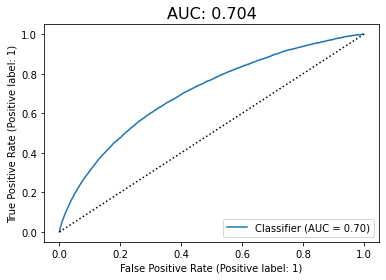


Métricas de avaliação de teste:


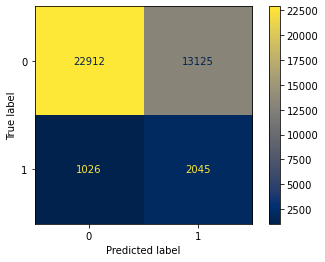

              precision    recall  f1-score   support

           0       0.96      0.64      0.76     36037
           1       0.13      0.67      0.22      3071

    accuracy                           0.64     39108
   macro avg       0.55      0.65      0.49     39108
weighted avg       0.89      0.64      0.72     39108



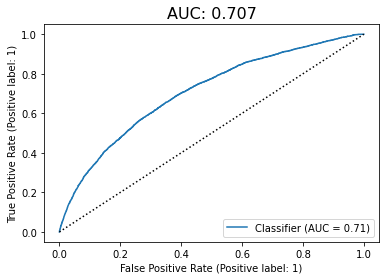

In [43]:
metricas_classificacao(pipe_abc1, X_res, X_test, y_res, y_test)

# Aplicando os dados de teste

In [44]:
teste = pd.read_csv('application_test_student.csv')

In [45]:
df2 = pd.merge(teste,cash,how='left')
df3 = pd.merge(df2,bc,how='left')
df4 = pd.merge(df3,payment,how='left')
teste_pronto = pd.merge(df4,cartao,how='left')

In [46]:
pipe_abc1.predict(teste_pronto[colunas_teste])

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

In [47]:
teste_pronto = pd.concat(
    (teste_pronto,
     pd.Series(pipe_abc1.predict(teste_pronto[colunas_teste]), name='TARGET')),
    axis=1)

In [48]:
valor = teste_pronto.groupby(by='TARGET')[['AMT_CREDIT']].sum().reset_index()

In [49]:
valor

,TARGET,AMT_CREDIT
0,0,2.157478e+10
1,1,1.514037e+10


In [50]:
int(teste_pronto['AMT_CREDIT'].sum())

36715147569

Motivos para modelo ser adotado:

1) O modelo apresenta um recall de 67% o que indica que para todos aqueles que o modelo previu ser mau pagador ele errou 33% o que pode representar 10144047156 de valor de crédito não cedidos a maus pagadores dos dados de teste.

2) O modelo apresenta uma precisão de 96% o que quer dizer que de todos aqueles que o modelo previu como bons pagadores apenas 4% não eram de fato bons pagadores, o que pode representar que 20838527568 valor do total de creditos a serem cedidos somente 833541102 de valor corre o risco de não retornar. 

# Salvando o arquivo 

In [53]:
pipe_abc1.predict_proba(teste_pronto[colunas_teste])[:,1]

array([0.50047066, 0.49862763, 0.49922573, ..., 0.49959179, 0.50084285,
       0.5003355 ])

In [54]:
submission = pd.concat(
    (teste_pronto['SK_ID_CURR'],
     pd.Series(pipe_abc1.predict_proba(teste_pronto[colunas_teste])[:, 1],
               name='TARGET')),
    axis=1)

In [55]:
submission.to_csv('submission_final.csv')